In [3]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_lg_data) = wavfile.read('./data/01_gr-jump-head-lg.wav')
(target_fs, target_mg_data) = wavfile.read('./data/01_gr-jump-head-mg.wav')
(target_fs, target_hg_data) = wavfile.read('./data/01_gr-jump-head-hg.wav')
(target_fs, target_lm_data) = wavfile.read('./data/01_gr-jump-head-lm.wav')
(target_fs, target_mm_data) = wavfile.read('./data/01_gr-jump-head-mm.wav')
(target_fs, target_hm_data) = wavfile.read('./data/01_gr-jump-head-hm.wav')

FileNotFoundError: [Errno 2] No such file or directory: './data/01_gr-jump-head-lm.wav'

In [ ]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

,L,R
0,1,-1
1,-5,-6
2,-11,-12
3,-18,-17
4,-24,-24


In [1]:
target_lg_df = pd.DataFrame(target_lg_data, columns=['L', 'R'])
target_lg_df.head()

NameError: name 'pd' is not defined

In [5]:
target_mg_df = pd.DataFrame(target_mg_data, columns=['L', 'R'])
target_mg_df.head()

,L,R
0,0,-1
1,0,0
2,0,-1
3,0,0
4,1,0


In [6]:
target_hg_df = pd.DataFrame(target_hg_data, columns=['L', 'R'])
target_hg_df.head()

,L,R
0,1,0
1,0,0
2,0,1
3,0,0
4,0,1


In [7]:
source_df['L'].max(), target_lg_df['L'].max(), target_mg_df['L'].max(), target_hg_df['L'].max()

(10790, 19284, 23459, 24606)

In [8]:
2 ** 15

32768

In [9]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [10]:
len(source_df), len(target_lg_df), len(target_mg_df), len(target_hg_df)

(1302647, 1302647, 1302647, 1302647)

## Data processing

In [281]:
N_SAMPLES_IN_CHUNK = 4000

In [209]:
# END_LOC = int(len(target_df) * 0.8)
N_TRAIN = int(N_SAMPLES_IN_CHUNK * 0.8 / 100) * 100
N_TEST = N_SAMPLES_IN_CHUNK - N_TRAIN
N_TRAIN, N_TEST

(70400, 17600)

In [210]:
import numpy as np

In [211]:
X_train_raw_lg = pd.Series(list(map(lambda x: [x, 1], source_df['L'][:N_TRAIN])))
X_train_raw_mg = pd.Series(list(map(lambda x: [x, 2.2], source_df['L'][:N_TRAIN])))
X_train_raw_hg = pd.Series(list(map(lambda x: [x, 6.4], source_df['L'][:N_TRAIN])))

# X_train_raw = pd.Series(np.concatenate([X_train_raw_lg, X_train_raw_mg, X_train_raw_hg]))
len(X_train_raw_lg), len(X_train_raw_mg), len(X_train_raw_hg)

(70400, 70400, 70400)

In [212]:
X_test_raw_lg = pd.Series(list(map(lambda x: [x, 1], source_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])))
X_test_raw_mg = pd.Series(list(map(lambda x: [x, 2.2], source_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])))
X_test_raw_hg = pd.Series(list(map(lambda x: [x, 6.4], source_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])))

# X_test_raw = pd.Series(np.concatenate([X_test_raw_lg, X_test_raw_mg, X_test_raw_hg]))
len(X_test_raw_lg), len(X_test_raw_mg), len(X_test_raw_hg)

(17600, 17600, 17600)

In [213]:
# y_train_raw = np.concatenate([
#     target_lg_df['L'][:TR_END_LOC],
#     target_mg_df['L'][:TR_END_LOC],
#     target_hg_df['L'][:TR_END_LOC]
# ])

y_train_raw_lg = pd.Series(target_lg_df['L'][:N_TRAIN])
y_train_raw_mg = pd.Series(target_mg_df['L'][:N_TRAIN])
y_train_raw_hg = pd.Series(target_hg_df['L'][:N_TRAIN])

len(y_train_raw_lg), len(y_train_raw_mg), len(y_train_raw_hg)

(70400, 70400, 70400)

In [214]:
y_test_raw_lg = pd.Series(target_lg_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])
y_test_raw_mg = pd.Series(target_mg_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])
y_test_raw_hg = pd.Series(target_hg_df['L'][N_TRAIN:N_SAMPLES_IN_CHUNK])

len(y_test_raw_lg), len(y_test_raw_mg), len(y_test_raw_hg)

(17600, 17600, 17600)

In [215]:
# y_test_raw = np.concatenate([
#     target_lg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK],
#     target_mg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK],
#     target_hg_df['L'][TR_END_LOC:N_SAMPLES_IN_CHUNK]
# ])

# len(y_test_raw)

In [216]:
X_test_raw_lg.iloc[:10]

0    [-959, 1]
1    [-935, 1]
2    [-892, 1]
3    [-831, 1]
4    [-751, 1]
5    [-644, 1]
6    [-512, 1]
7    [-357, 1]
8    [-189, 1]
9     [-15, 1]
dtype: object

In [217]:
# safe-checking data

In [218]:
# y_train_raw = -y_train_raw + 4000
# y_train_raw.iloc[0]

In [219]:
# y_test_raw = -y_test_raw + 4000
# y_test_raw.iloc[0]

In [220]:
N_SAMPLES = N_SAMPLES_IN_CHUNK * 3
n_features = 2
N_WINDOW_POINTS = 64

In [221]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [222]:
def make_windows(X, y, n_window_points):
    index = 0
    
    res_X = []
    res_y = []
    
    for index in range(0, min(len(X), len(y)) - n_window_points - 1):
        res_X.append(X[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [223]:
def norm_make_windows_and_reshape(X, y, n_samples, n_window_points):
    X_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE, x[1]]), X)))
    X_n = X_n.astype('float32')
    
    y_s = np.array(list(map(lambda x: np.array(x), y)))
    y_n = normalize(y_s, forced_abs=MAX_VALUE, mean=0.0)
    y_n = y_n.astype('float32')
    
    (X_f, y_f) = make_windows(
        X_n[:(n_samples + n_window_points + 1)],
        y_n[:(n_samples + n_window_points + 1)],
        n_window_points
    )
    
    return (X_f, y_f)

In [224]:
(X_tr_lg_f, y_tr_lg_f) = norm_make_windows_and_reshape(X_train_raw_lg, y_train_raw_lg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)
(X_tr_mg_f, y_tr_mg_f) = norm_make_windows_and_reshape(X_train_raw_mg, y_train_raw_mg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)
(X_tr_hg_f, y_tr_hg_f) = norm_make_windows_and_reshape(X_train_raw_hg, y_train_raw_hg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)

print(len(X_tr_lg_f), len(X_tr_mg_f), len(X_tr_hg_f))
print(len(y_tr_lg_f), len(y_tr_mg_f), len(y_tr_hg_f))

70335 70335 70335
70335 70335 70335


In [225]:
(X_te_lg_f, y_te_lg_f) = norm_make_windows_and_reshape(X_test_raw_lg, y_test_raw_lg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)
(X_te_mg_f, y_te_mg_f) = norm_make_windows_and_reshape(X_test_raw_mg, y_test_raw_mg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)
(X_te_hg_f, y_te_hg_f) = norm_make_windows_and_reshape(X_test_raw_hg, y_test_raw_hg, N_SAMPLES_IN_CHUNK, N_WINDOW_POINTS)

print(len(X_te_lg_f), len(X_te_mg_f), len(X_te_hg_f))
print(len(y_te_lg_f), len(y_te_mg_f), len(y_te_hg_f))

17535 17535 17535
17535 17535 17535


In [147]:
from matplotlib import pyplot as plt

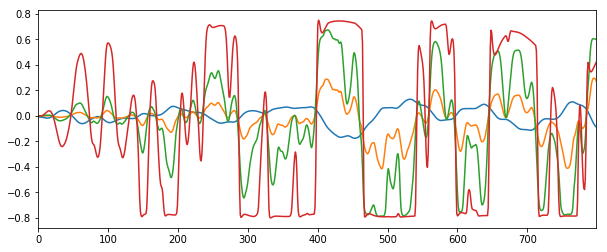

In [148]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(10, 4))

pd.Series(map(lambda x: x[-1][0], X_tr_lg_f[:800])).plot.line(ax=ax)
pd.Series(y_tr_lg_f[:800]).plot.line(ax=ax)
pd.Series(y_tr_mg_f[:800]).plot.line(ax=ax)
pd.Series(y_tr_hg_f[:800]).plot.line(ax=ax)

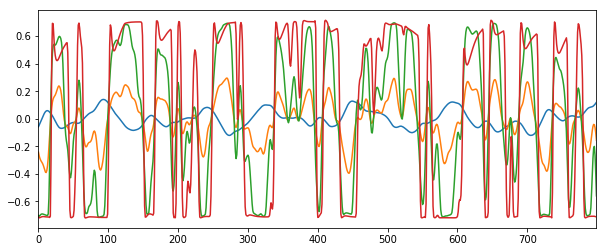

In [149]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(10, 4))

pd.Series(map(lambda x: x[-1][0], X_te_lg_f[:800])).plot.line(ax=ax)
pd.Series(y_te_lg_f[:800]).plot.line(ax=ax)
pd.Series(y_te_mg_f[:800]).plot.line(ax=ax)
pd.Series(y_te_hg_f[:800]).plot.line(ax=ax)

In [227]:
X_tr_s = np.concatenate([X_tr_lg_f, X_tr_mg_f, X_tr_hg_f])
y_tr_s = np.concatenate([y_tr_lg_f, y_tr_mg_f, y_tr_hg_f])
     
len(X_tr_s), len(y_tr_s), np.min(X_tr_s)

(211005, 211005, -0.19690542)

In [228]:
X_te_s = np.concatenate([X_te_lg_f, X_te_mg_f, X_te_hg_f])
y_te_s = np.concatenate([y_te_lg_f, y_te_mg_f, y_te_hg_f])
     
len(X_te_s), len(y_te_s), np.min(X_te_s)

(52605, 52605, -0.22959074)

In [152]:
def add_stats(row):
    stats = [
        np.abs(row[-1]),
        -np.abs(row[-1]),
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
    ]

    return np.array([(list(x) + list(stats)) for x in row])

In [153]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [154]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

In [155]:
N_REPEAT = 4
N_REPEAT

4

In [156]:
X_tr_s[0][0]

array([3.051851e-05, 1.000000e+00], dtype=float32)

In [157]:
# X_tr_s = np.repeat(X_tr_s, N_REPEAT, axis=0)
# X_tr_s[0][0], X_tr_s[1][0]

In [116]:
# y_tr_s = np.repeat(y_tr_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

In [117]:
# X_te_s = np.repeat(X_te_s, N_REPEAT, axis=0)
# X_te_s[0][0], X_te_s[1][0]

In [118]:
# y_te_s = np.repeat(y_te_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

## Finished data processing!

## Moving on to training NN

In [119]:
import numpy as np

In [120]:
# num_steps=100, 24 hidden states

In [121]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

In [160]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((105405, 64, 2), (105405,), (26205, 64, 2), (26205,))

In [123]:
y_tr_s

array([-1.5259255e-04, -1.8311106e-04, -1.5259255e-04, ...,
        5.3889585e-01,  5.3999448e-01,  5.4100162e-01], dtype=float32)

In [124]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [125]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200, batch_size=1):
        self.model = model
        self.I = I
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        I = self.I
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(I))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = self.I
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I], batch_size=batch_size))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        # zeros = pd.Series(np.zeros(I))
        # zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(I, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [126]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    GRU_L = CuDNNGRU
    
    gru_1_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
        return_sequences=True,
    )(input_L)

    gru_2_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
    #     return_sequences=True,
    )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    # )(gru_1_l)
    )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params, verbose_fit=0):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(10 * (y_pred - y_true)), axis=-1)

    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.8
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    test_model_cb = TestModel(model, I=min(params['n_samples'], 2000), batch_size=params['batch_size'])

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
#         X_tr_s[:40],
#         y_tr_s[:40],
        batch_size=params['batch_size'],
        shuffle=False,
    #     epochs=400,
#         epochs=100,
        epochs=params['epochs'],
        verbose=verbose_fit,
#         validation_data=(X_te_s[:1000], y_te_s[:1000]),
        # validation_data=(X_te_s[:200], y_te_s[:200]),
        # callbacks=[es_cb, test_model_cb, tensorboard_cb],
        callbacks=[es_cb, test_model_cb, lrate],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

In [127]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()


  0%|          | 0/9 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


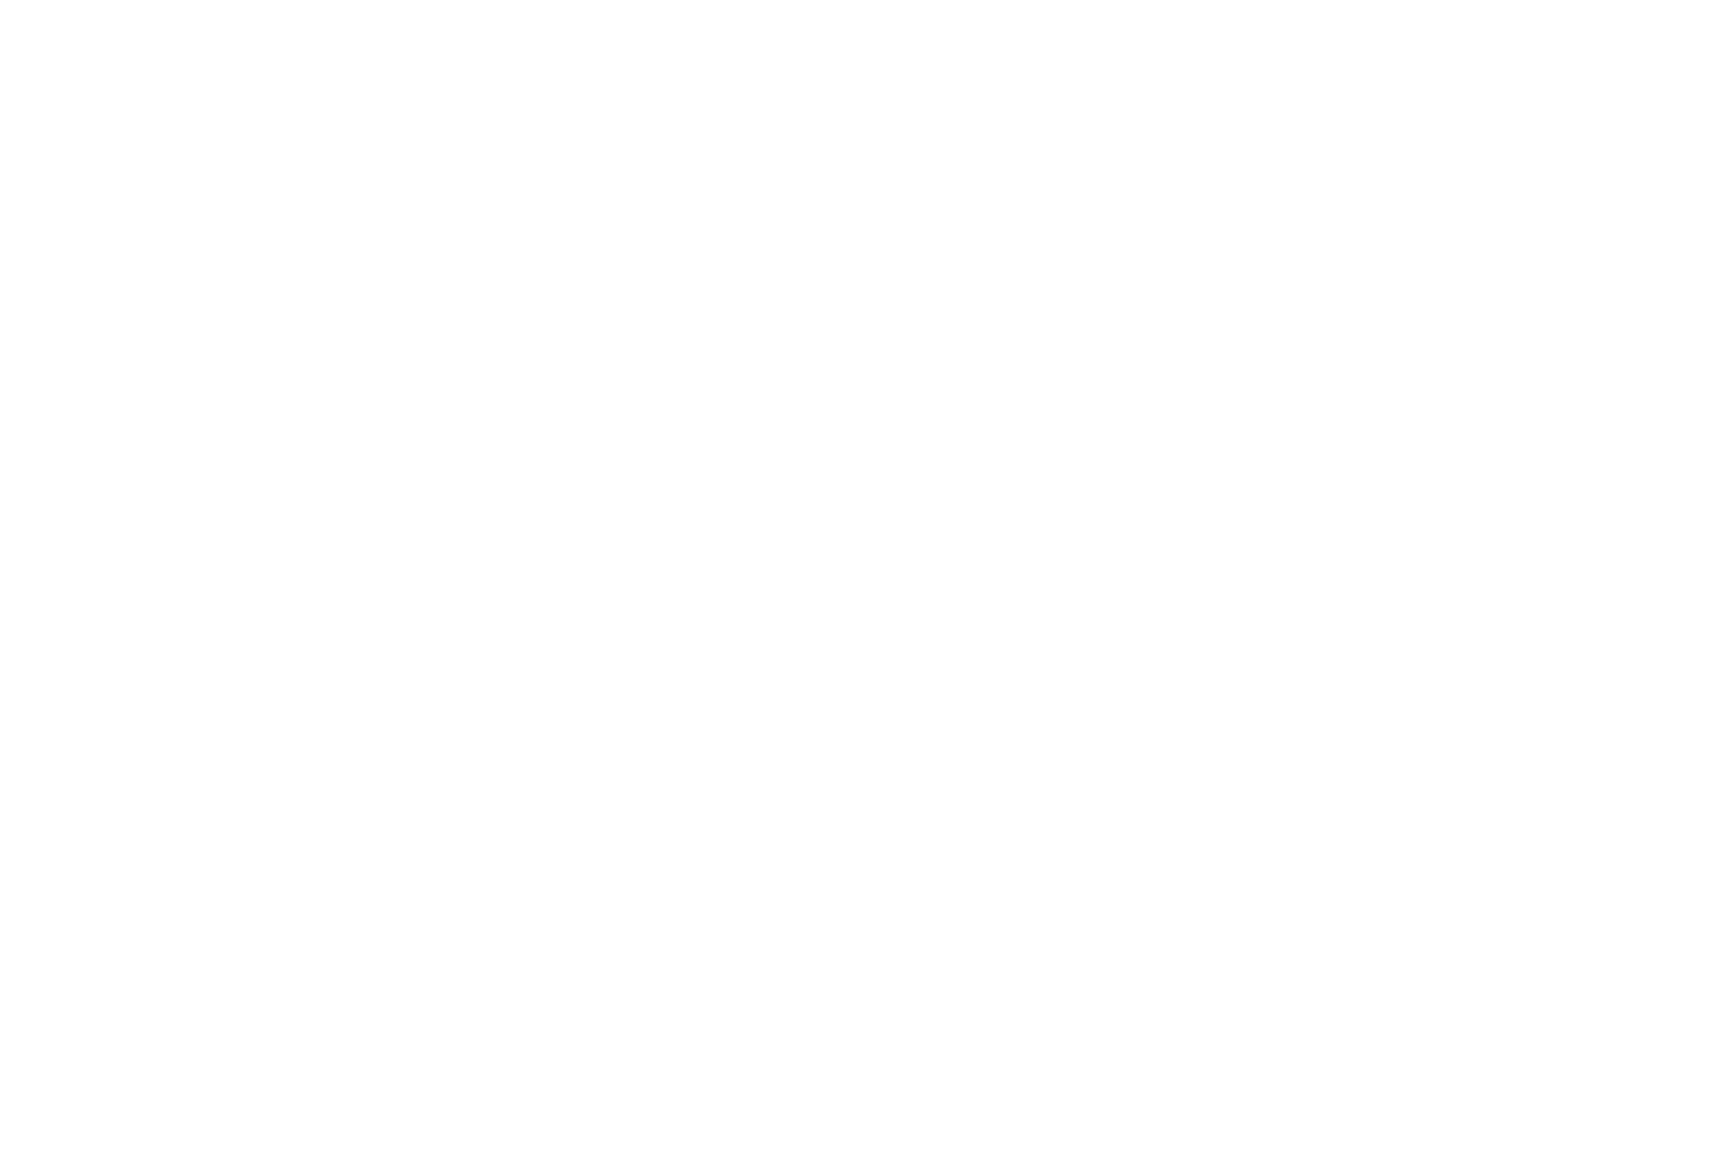


 11%|█         | 1/9 [00:53<07:10, 53.79s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


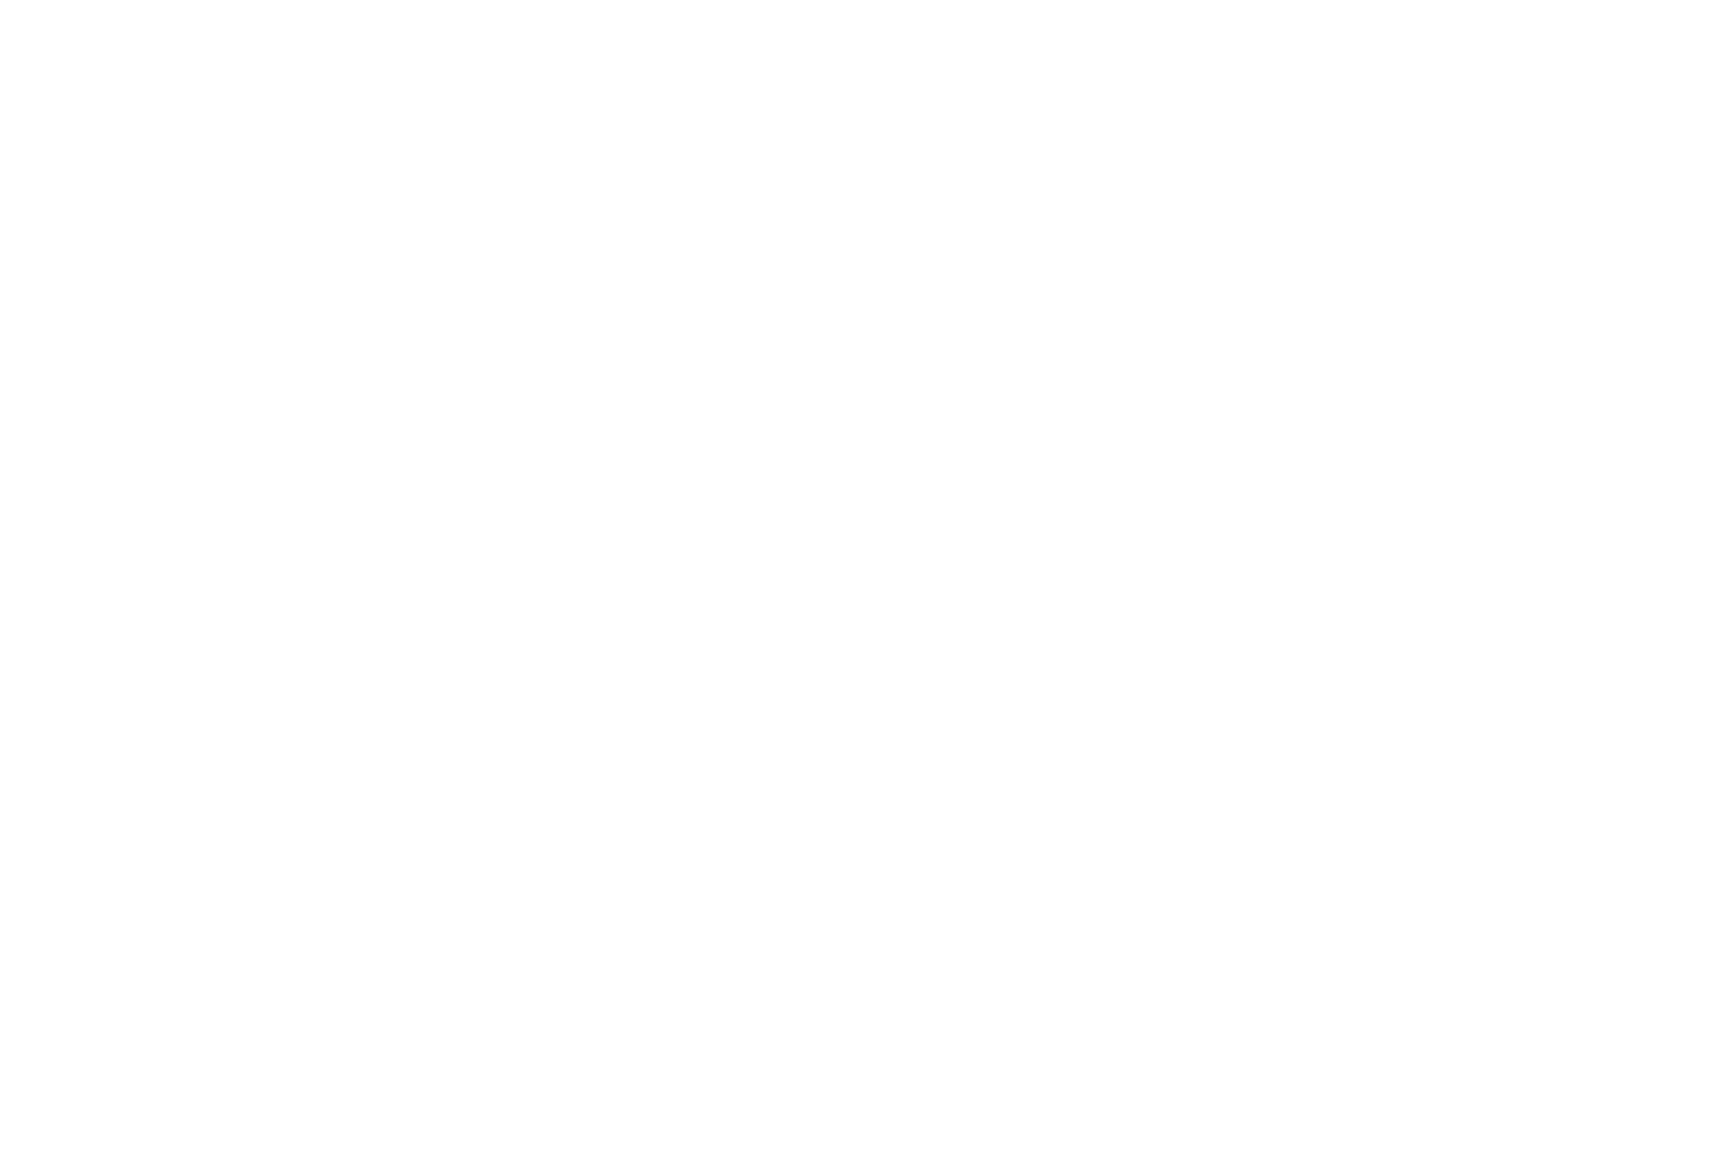


 22%|██▏       | 2/9 [01:48<06:18, 54.10s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


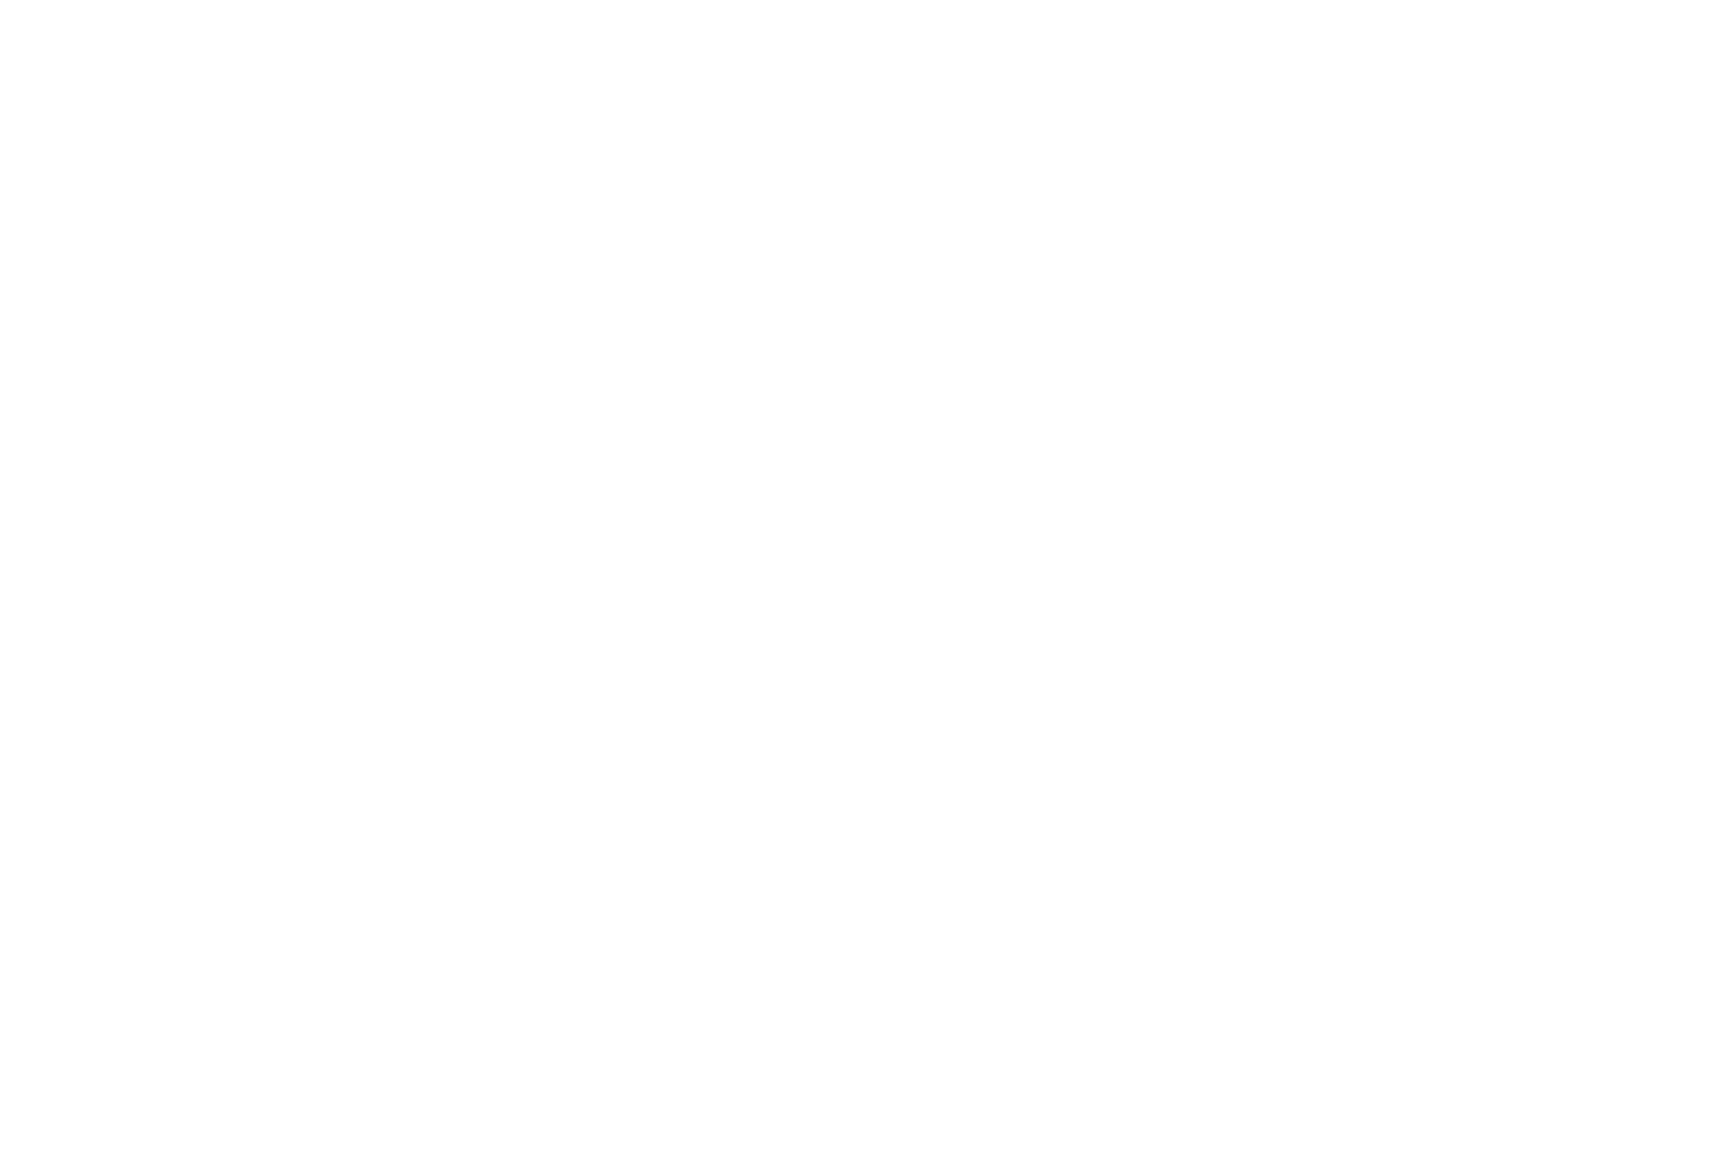


 33%|███▎      | 3/9 [02:43<05:25, 54.22s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


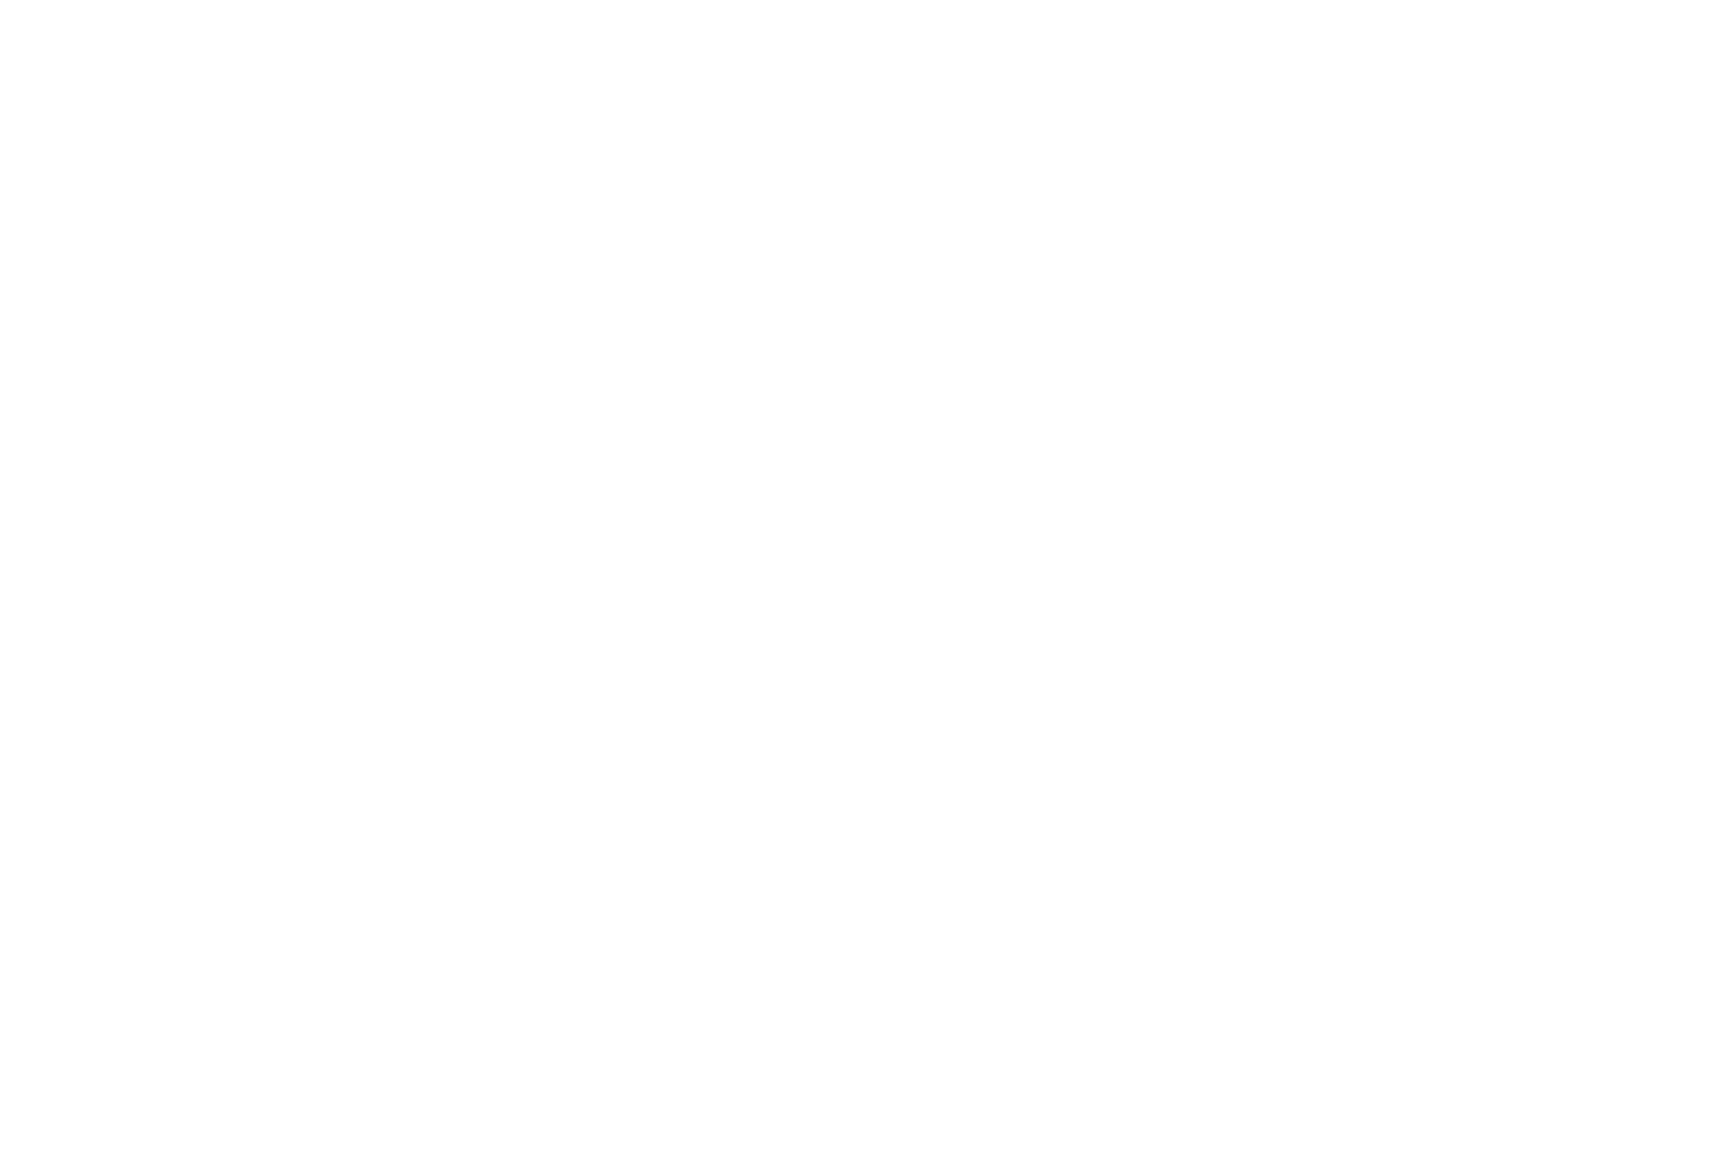


 44%|████▍     | 4/9 [03:36<04:29, 53.98s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


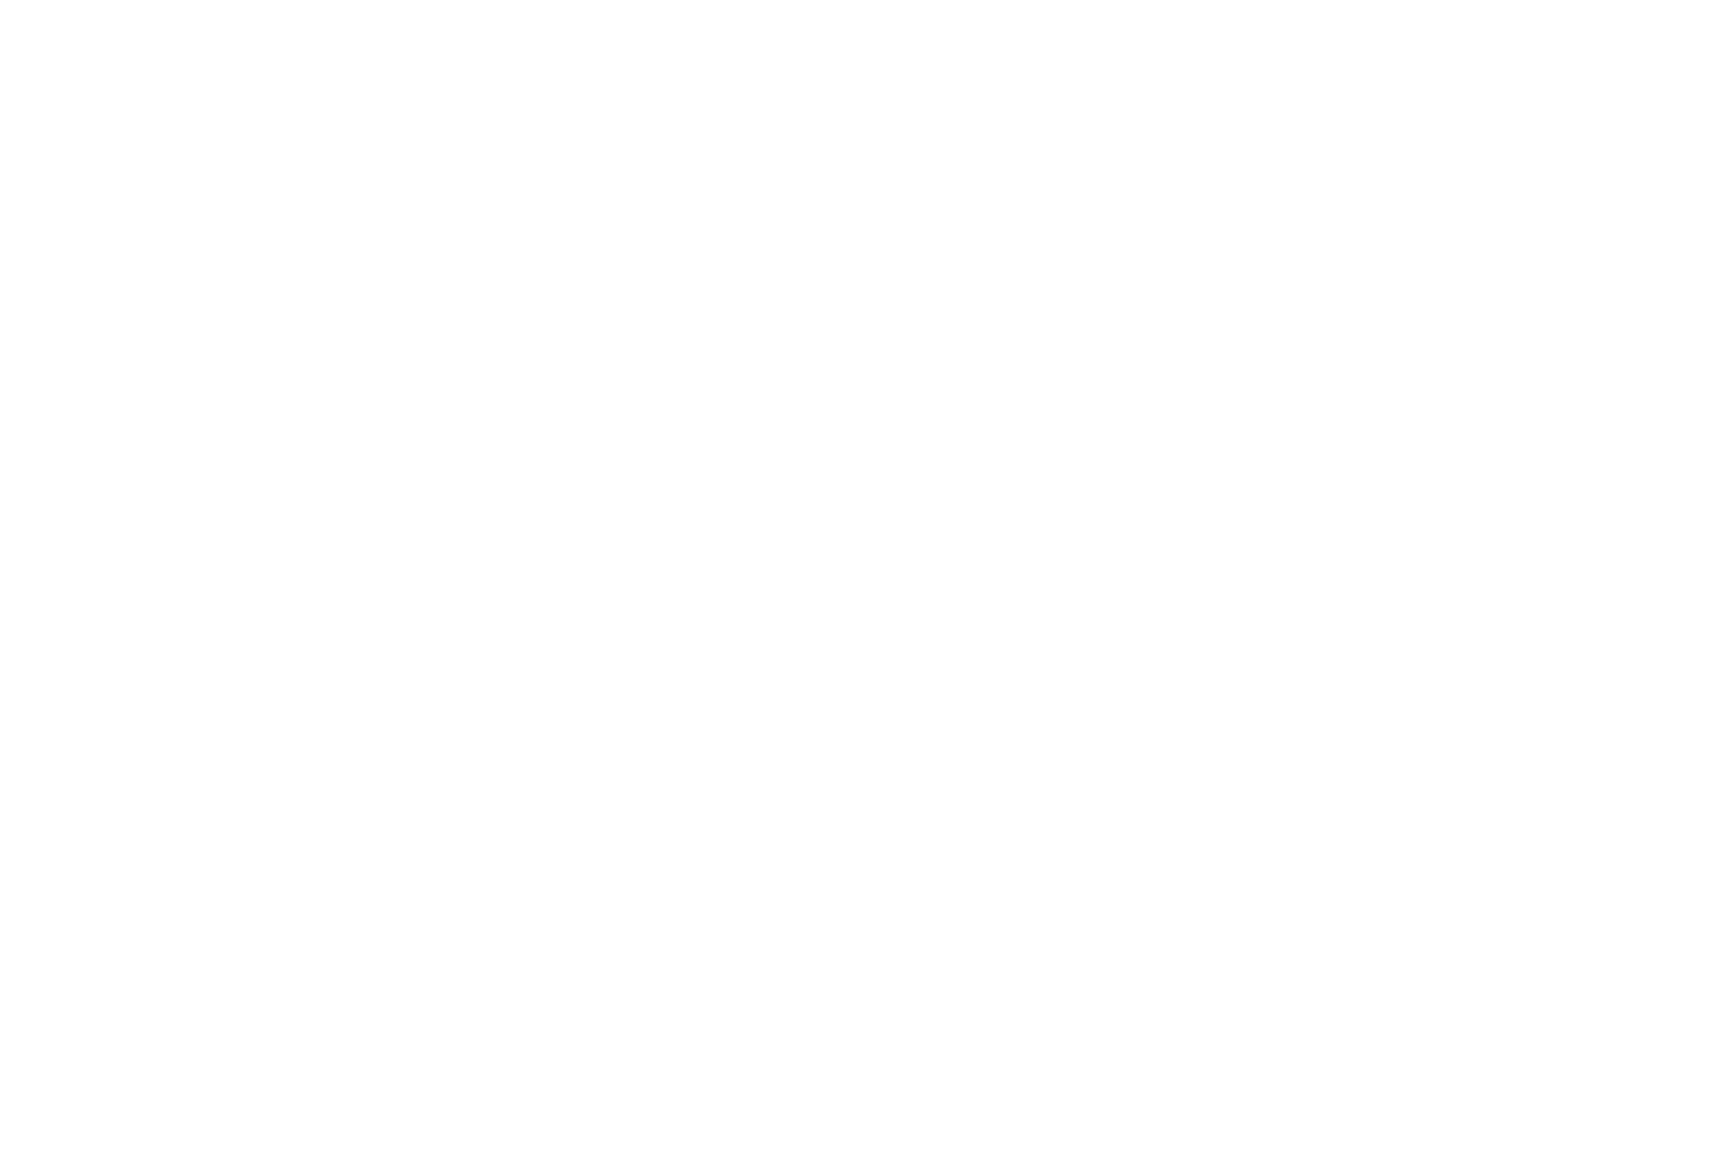


 56%|█████▌    | 5/9 [04:31<03:37, 54.28s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


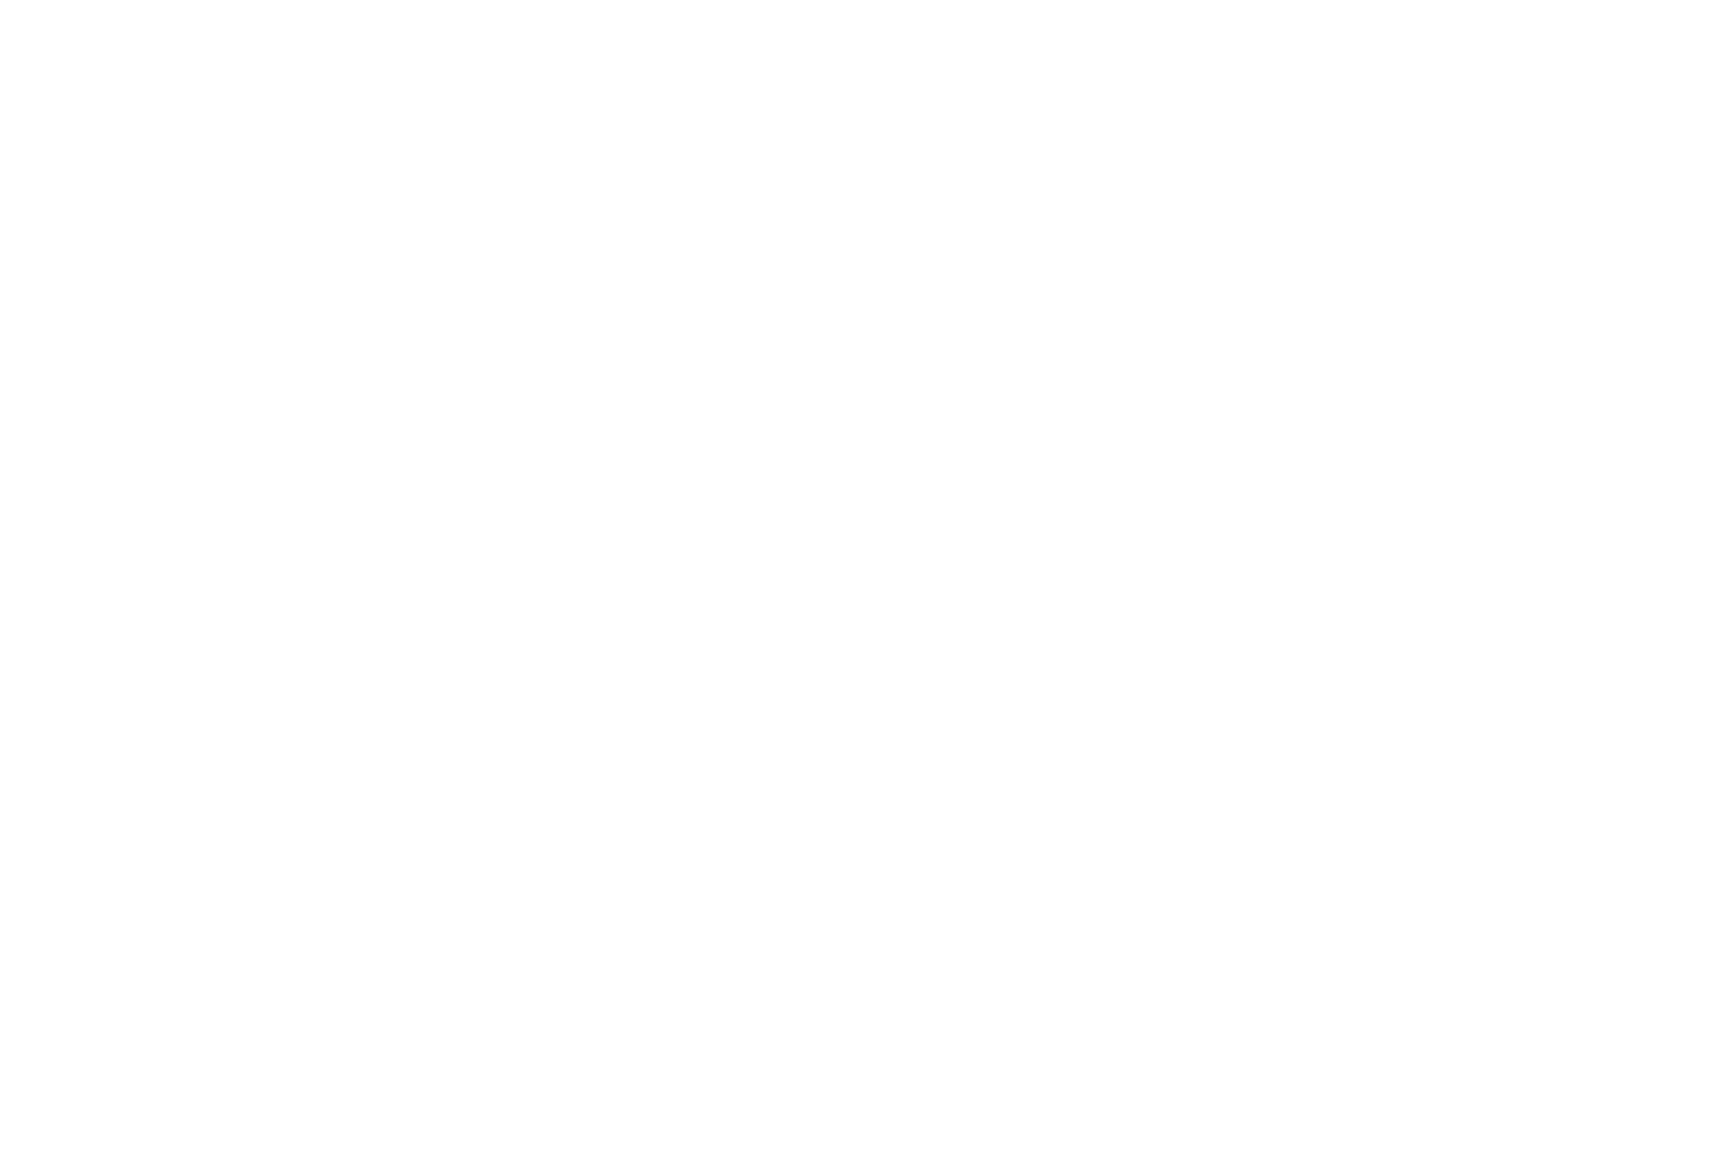


 67%|██████▋   | 6/9 [05:25<02:43, 54.34s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


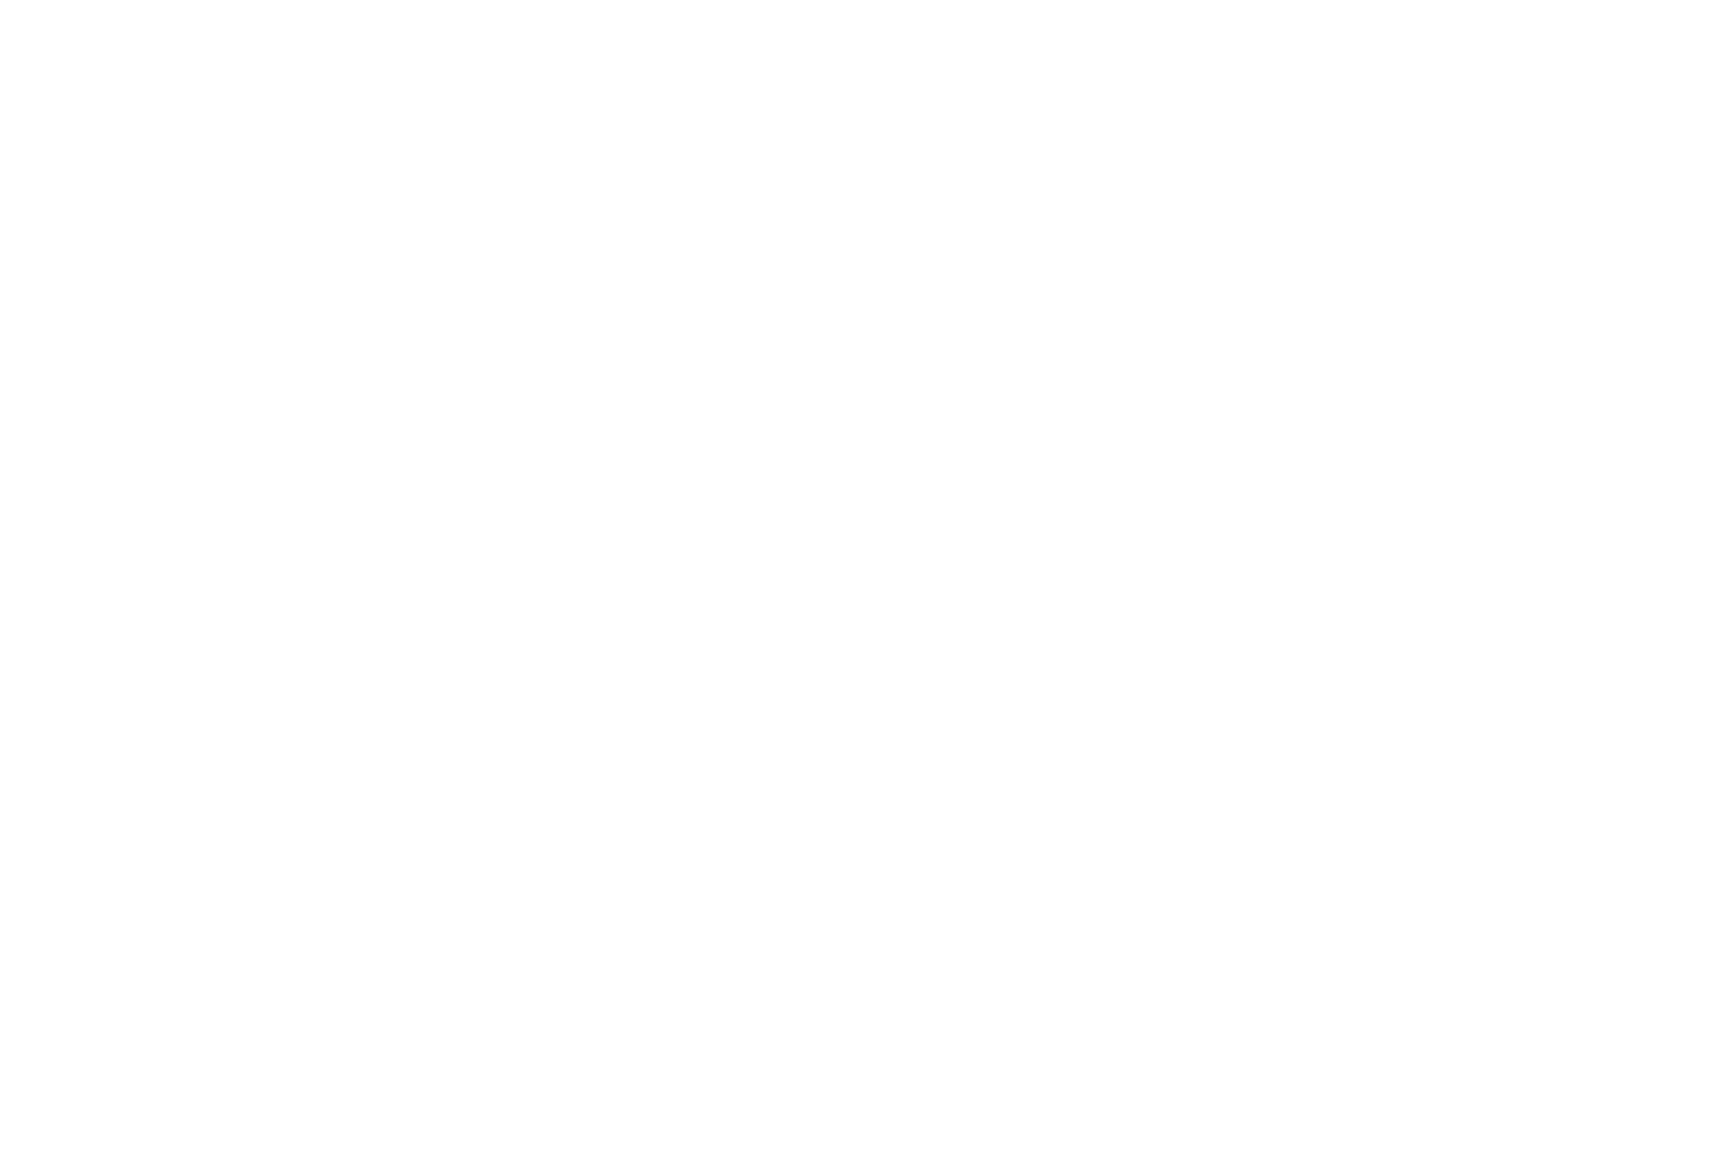


 78%|███████▊  | 7/9 [06:19<01:48, 54.06s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


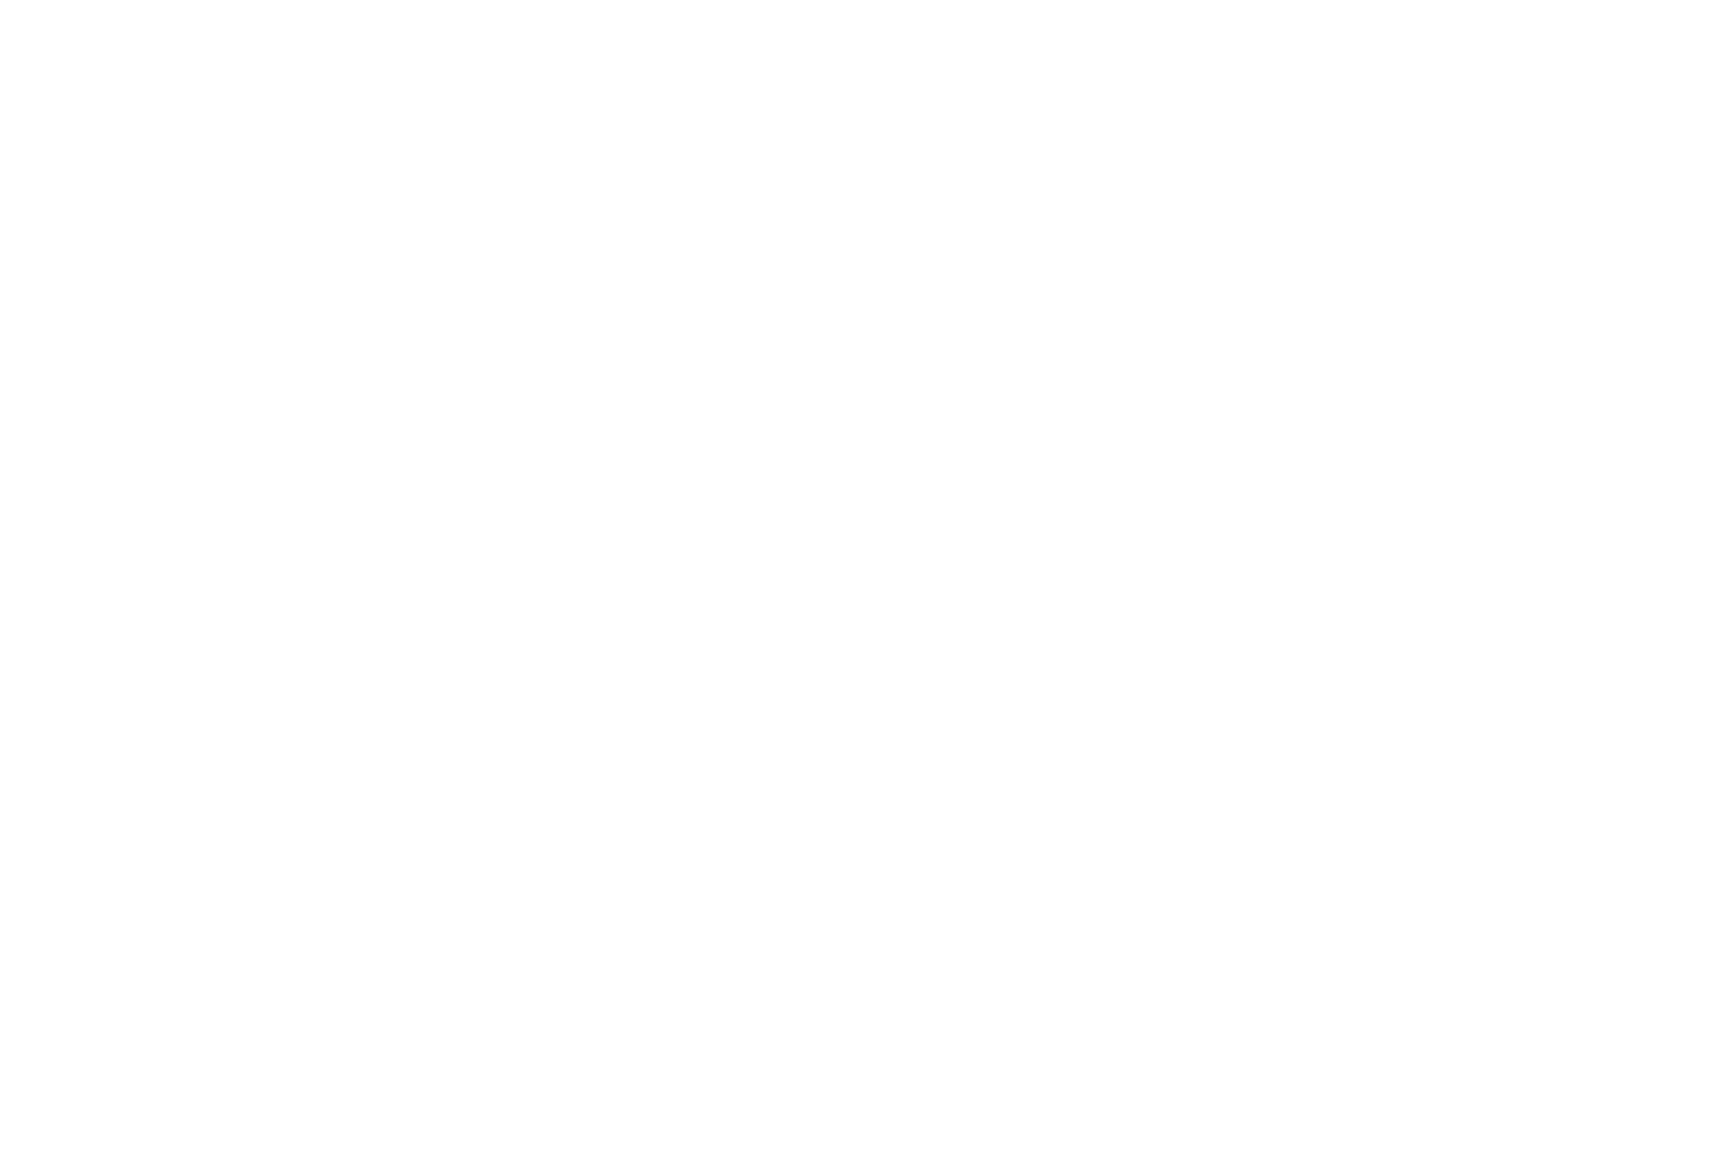


 89%|████████▉ | 8/9 [07:14<00:54, 54.25s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


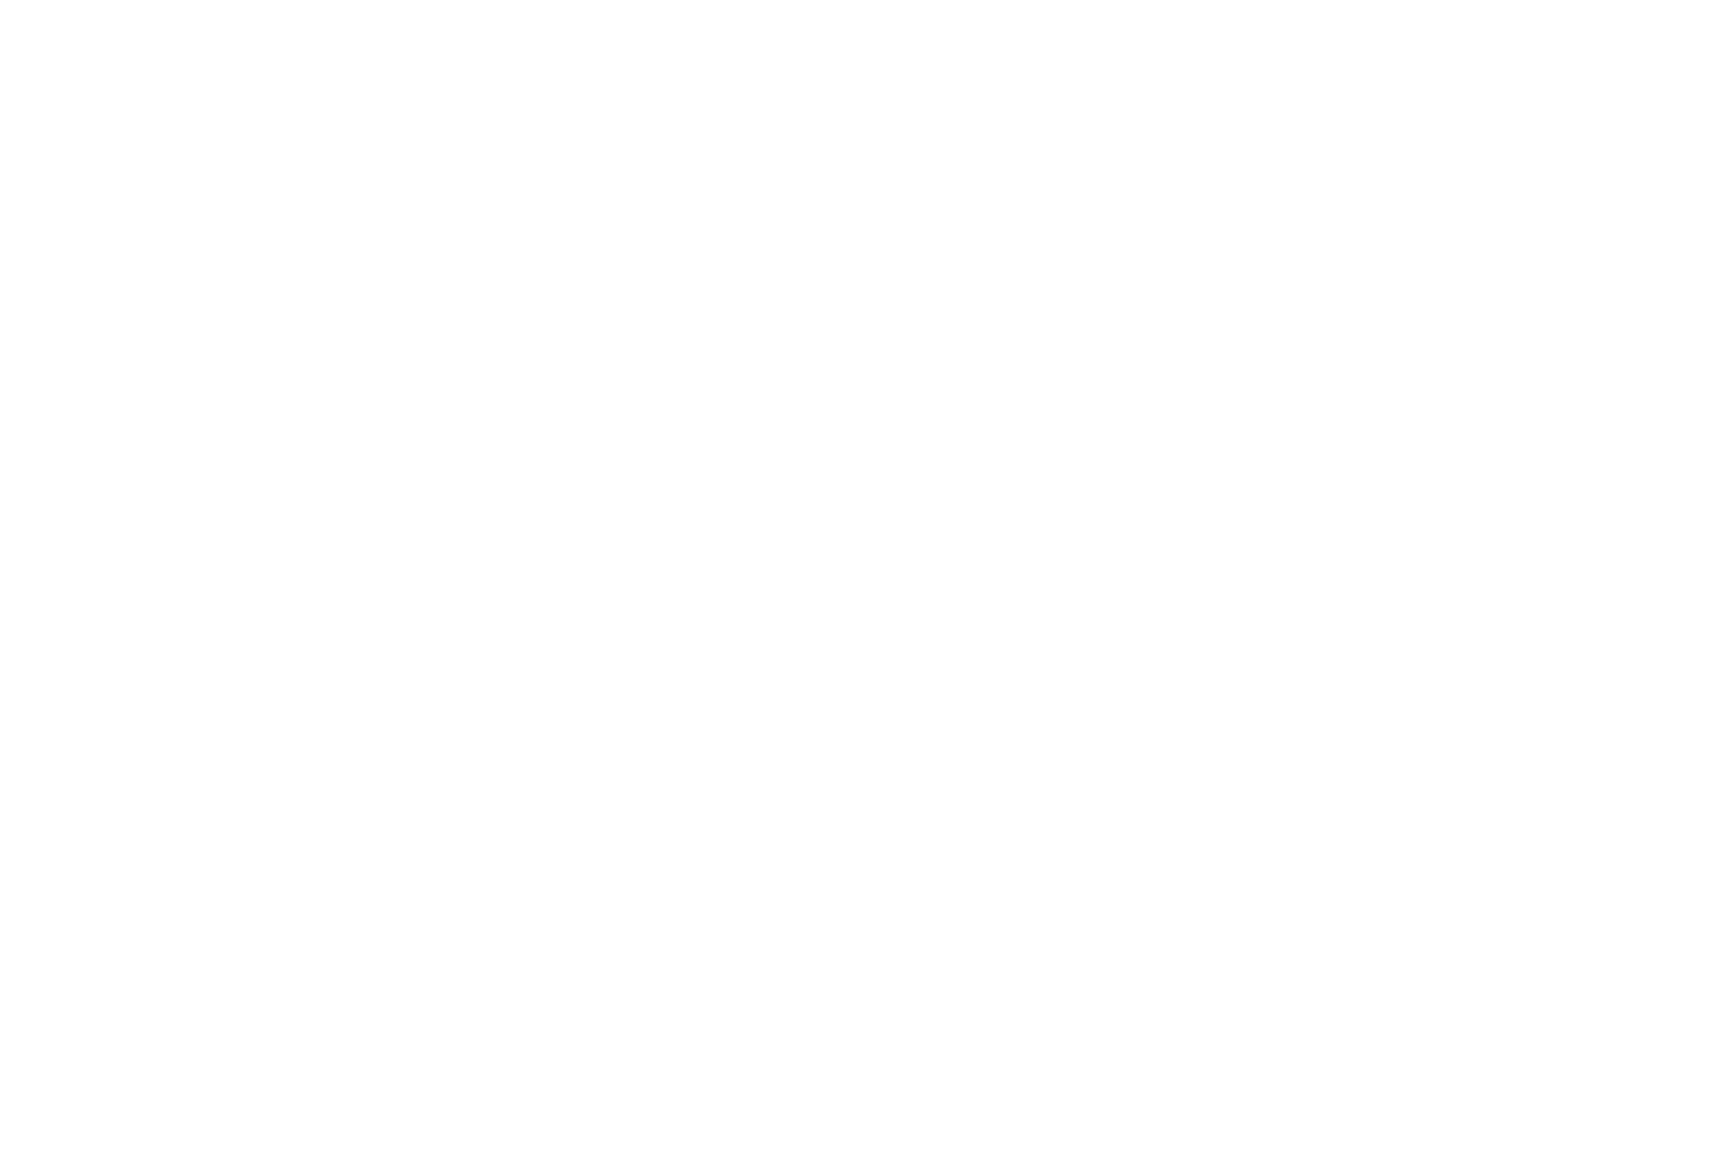


100%|██████████| 9/9 [08:08<00:00, 54.44s/it]

<IPython.core.display.Javascript object>


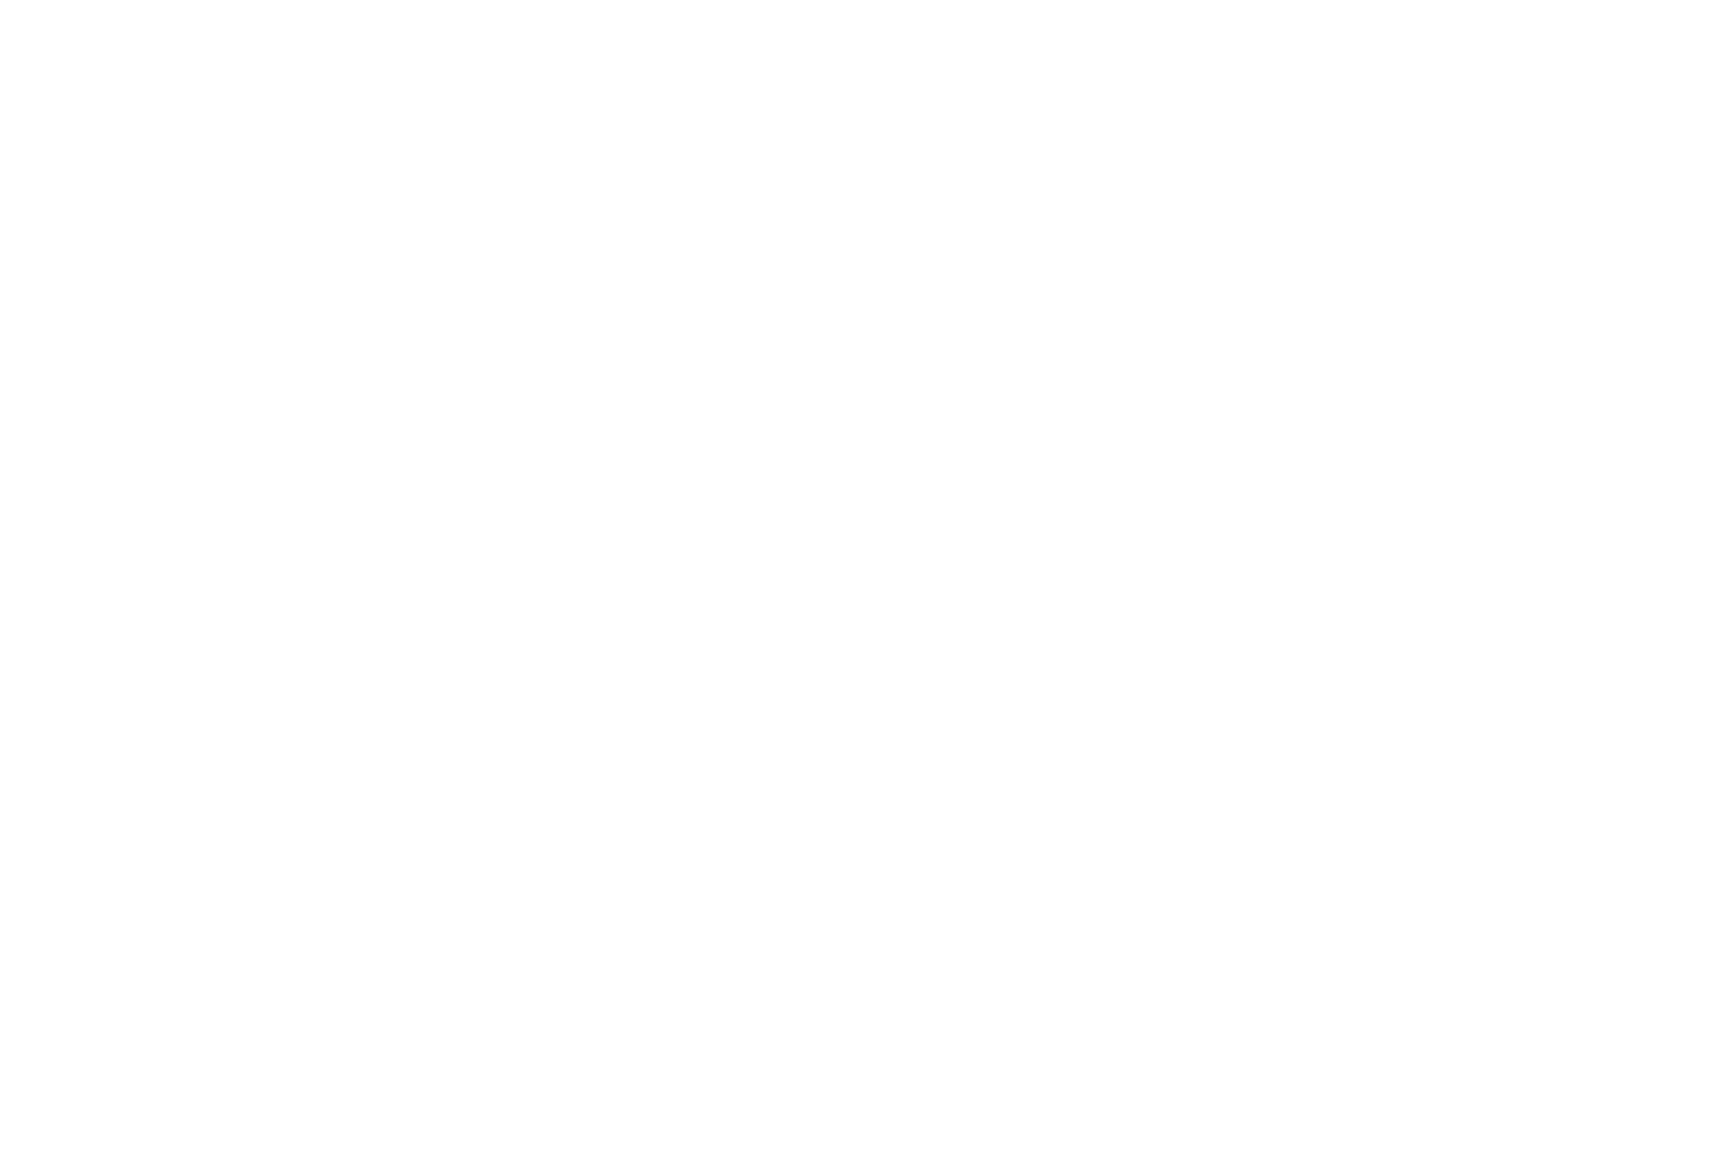

<IPython.core.display.Javascript object>


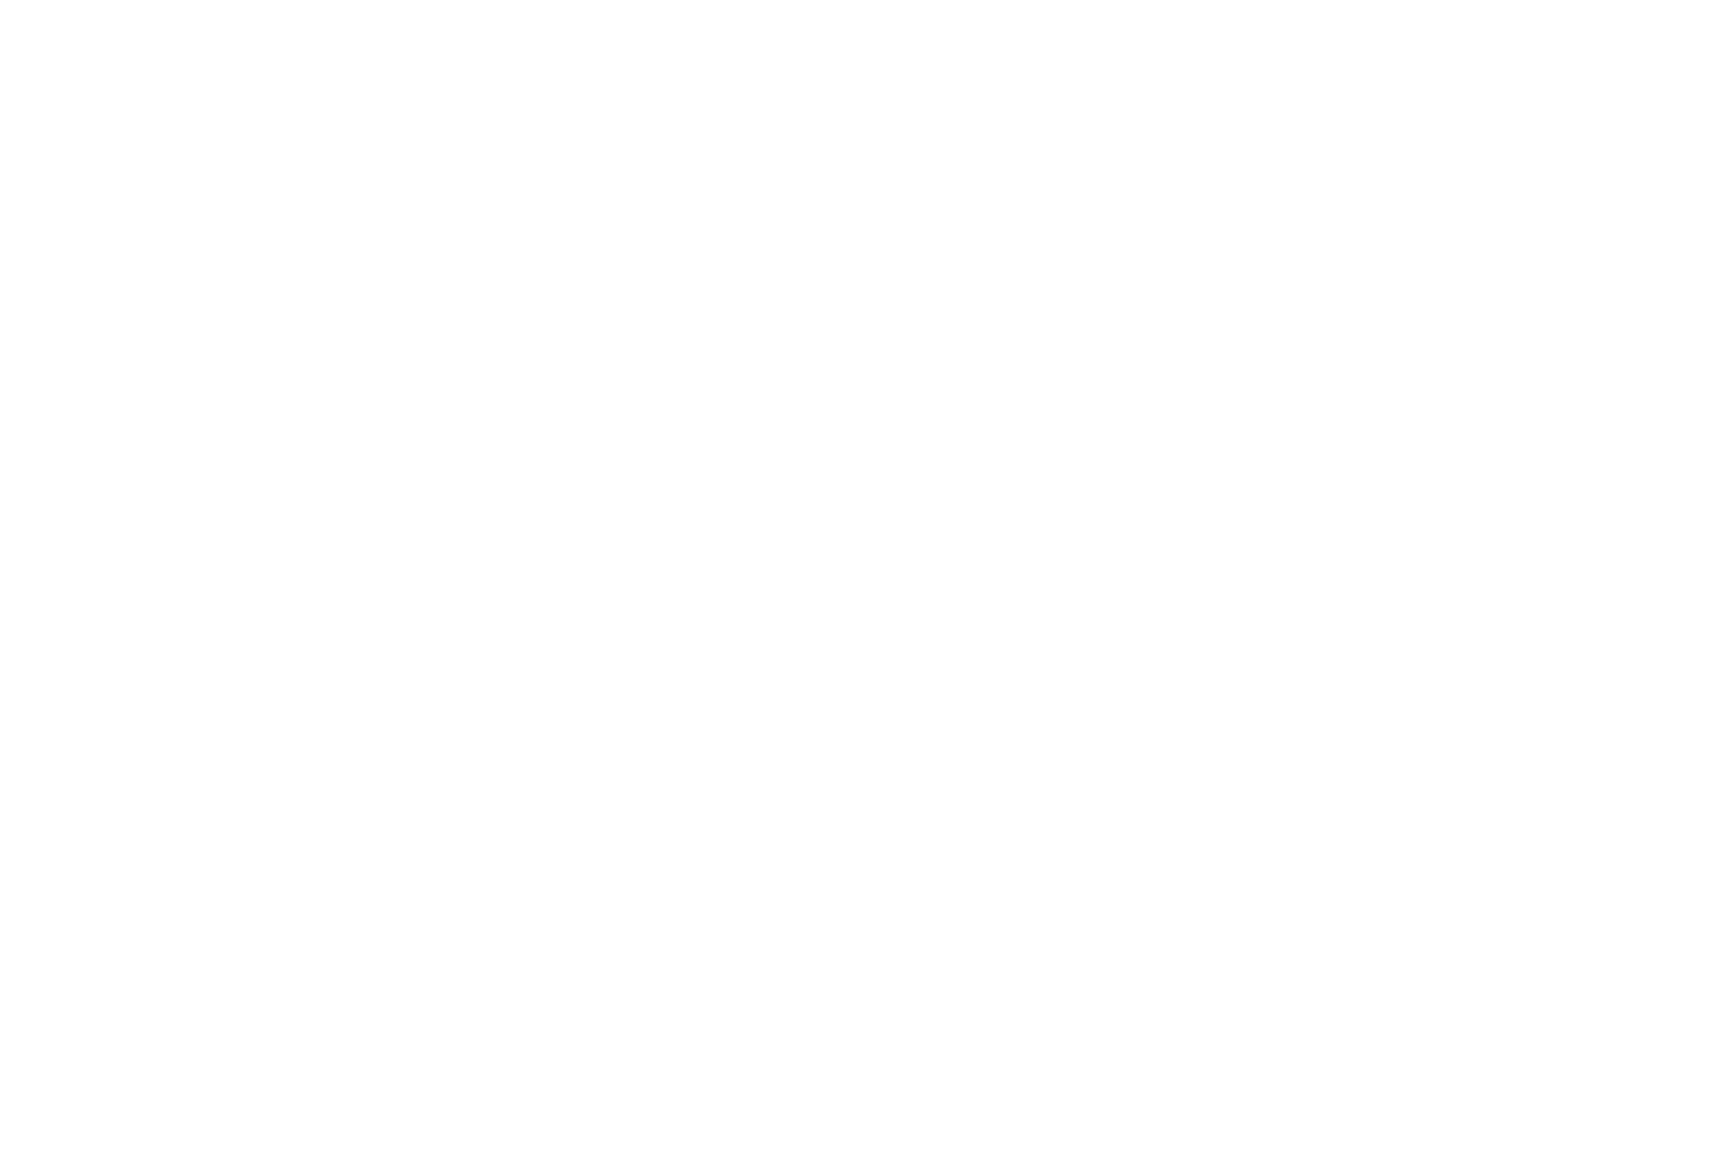

<IPython.core.display.Javascript object>


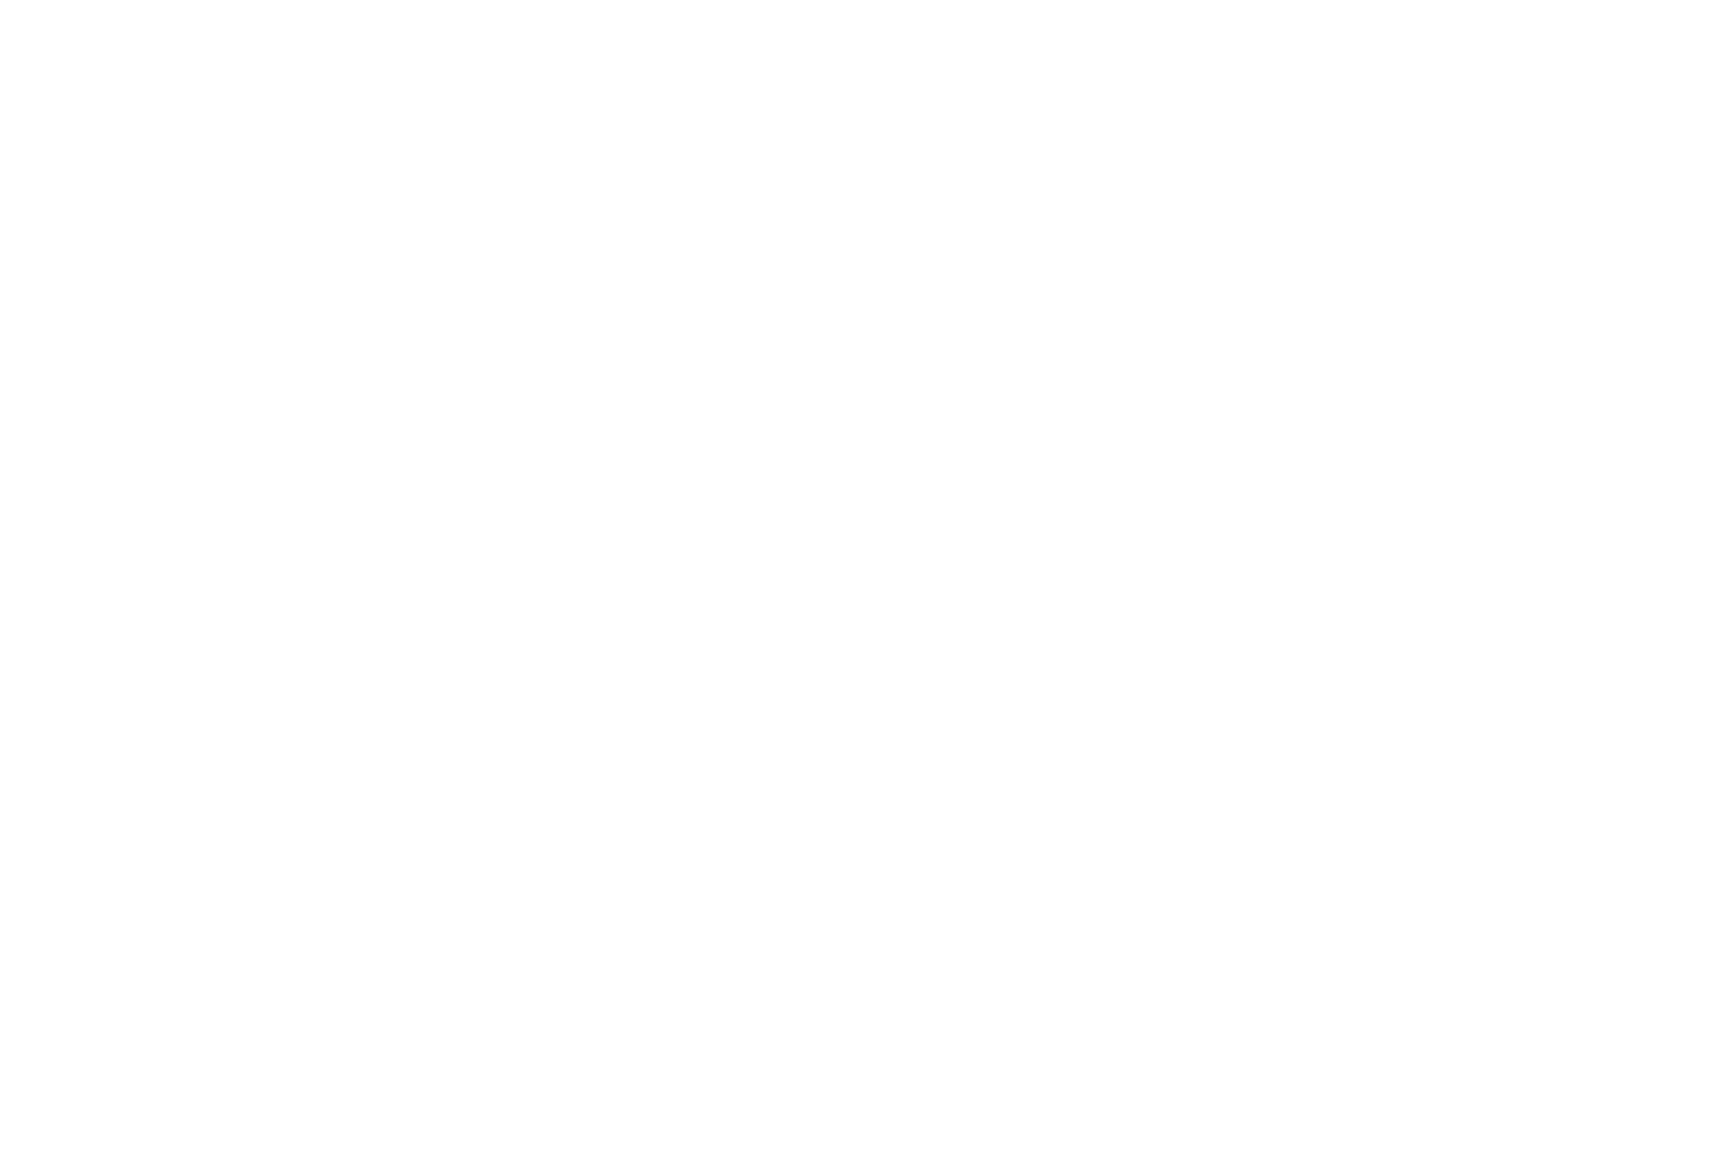

<IPython.core.display.Javascript object>


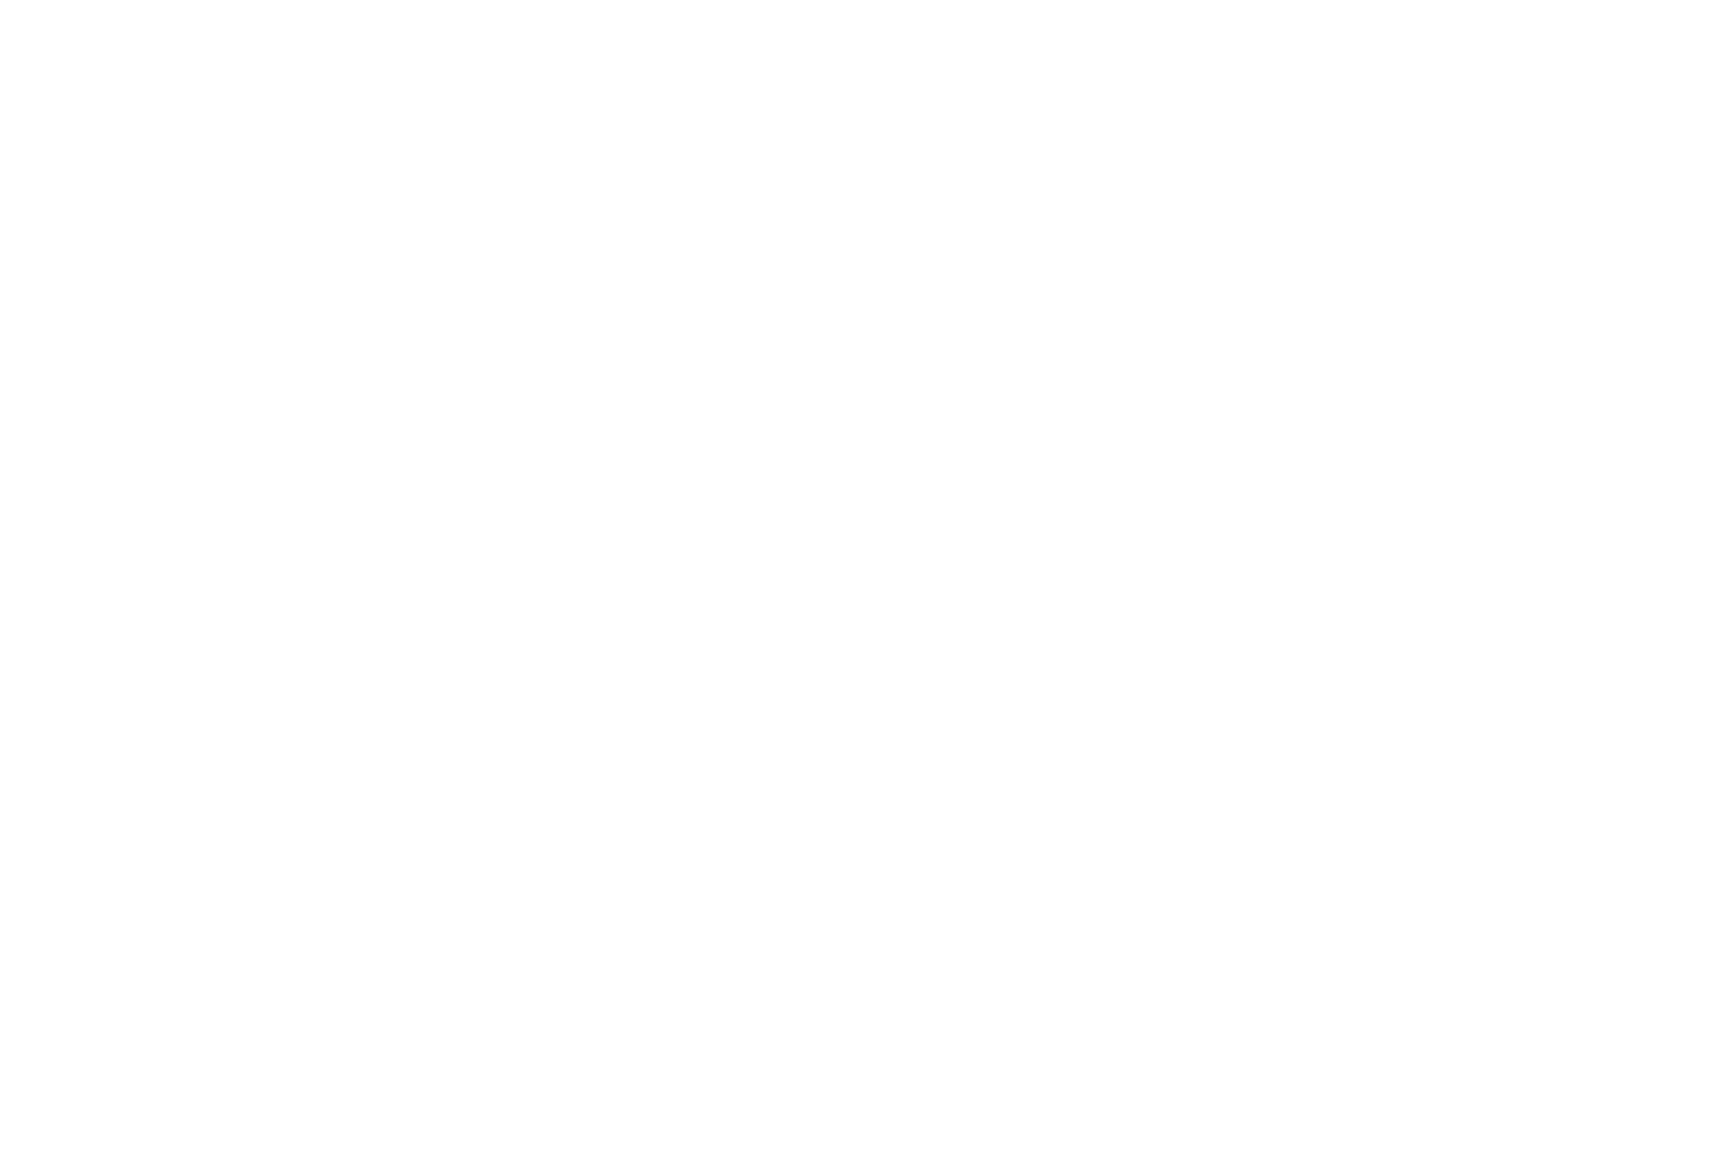

<IPython.core.display.Javascript object>


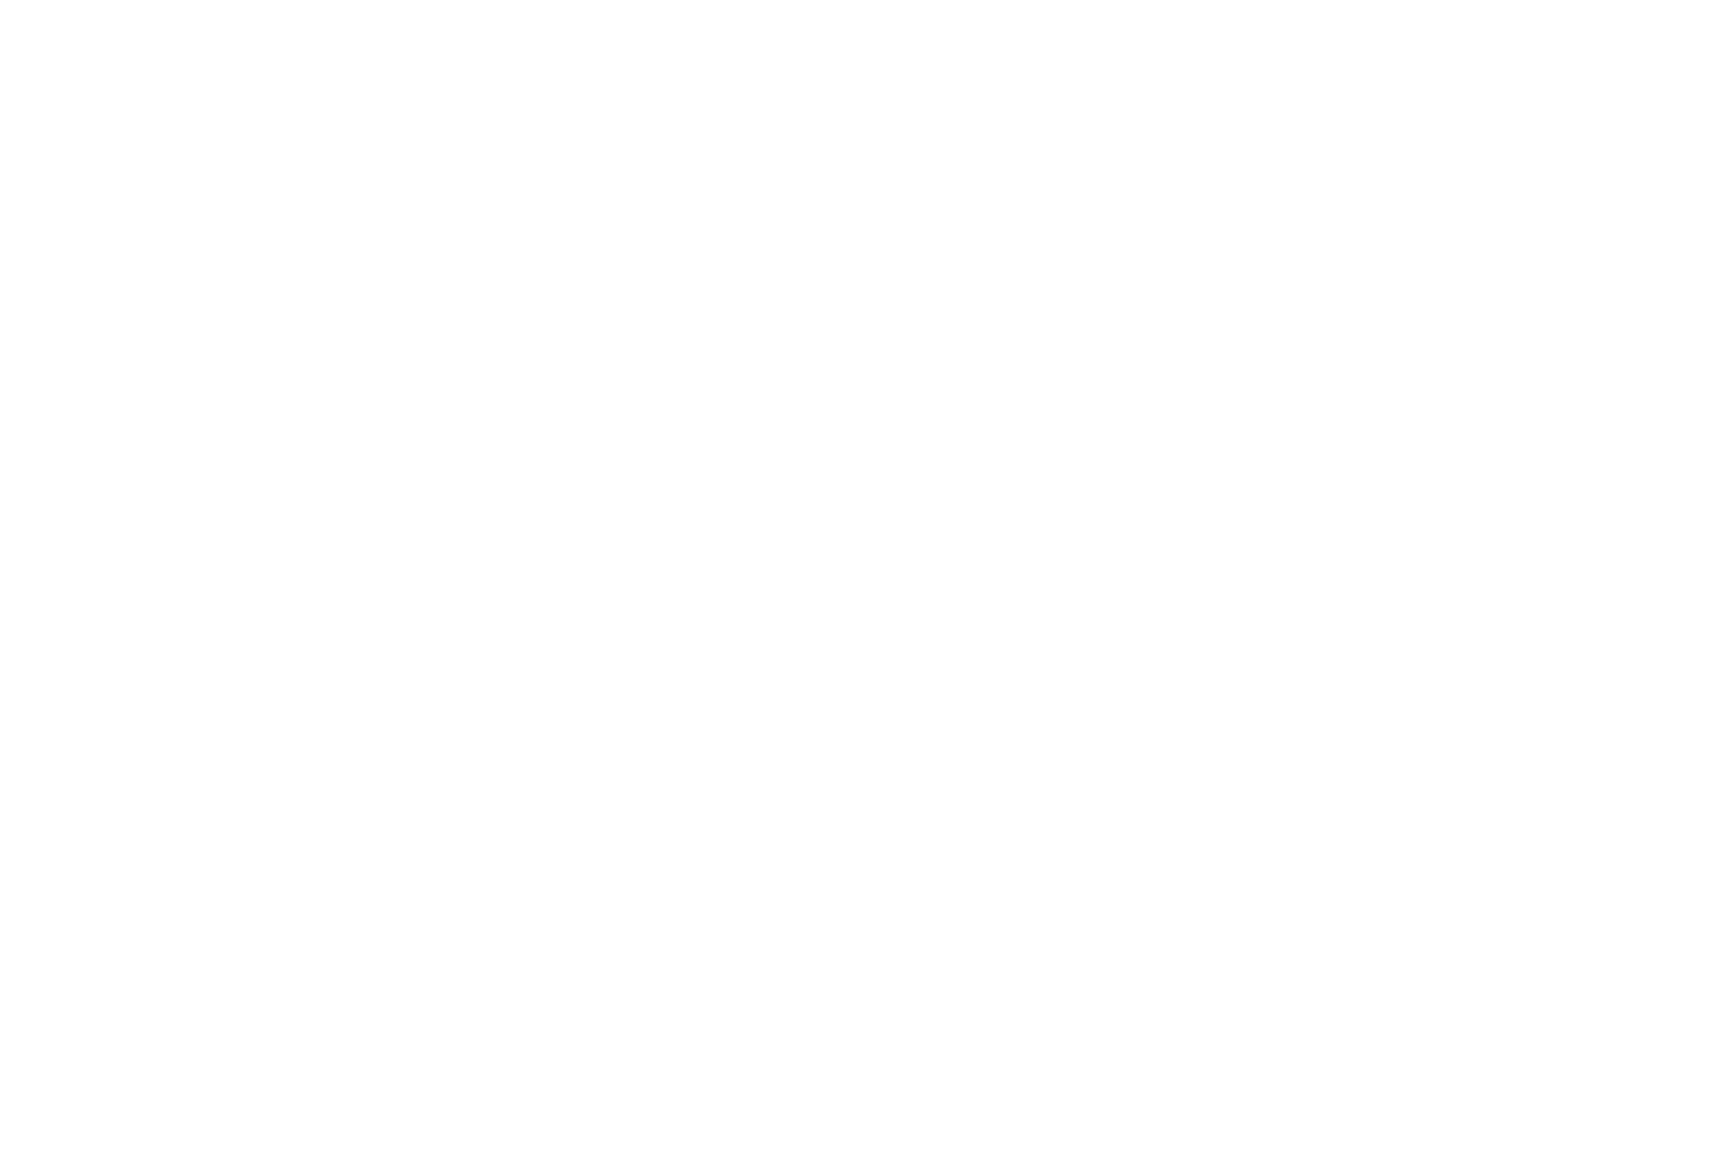

<IPython.core.display.Javascript object>


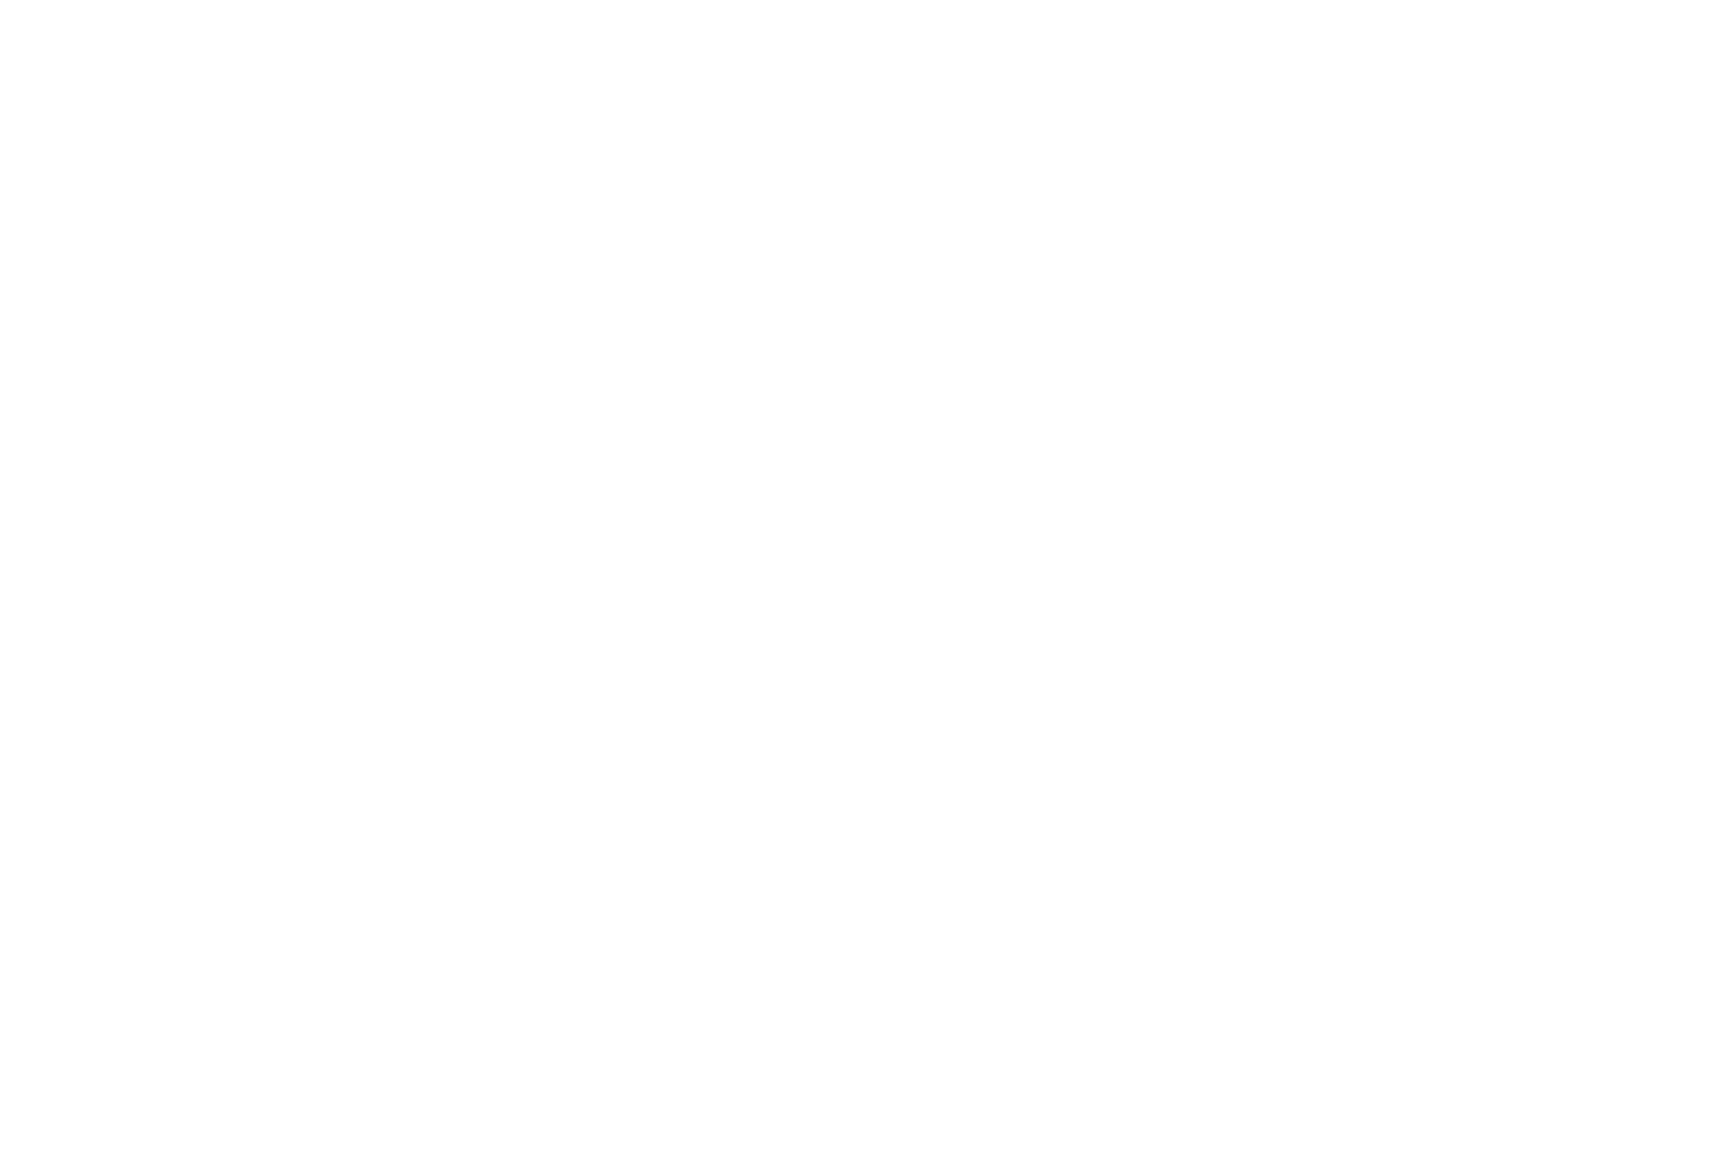

<IPython.core.display.Javascript object>


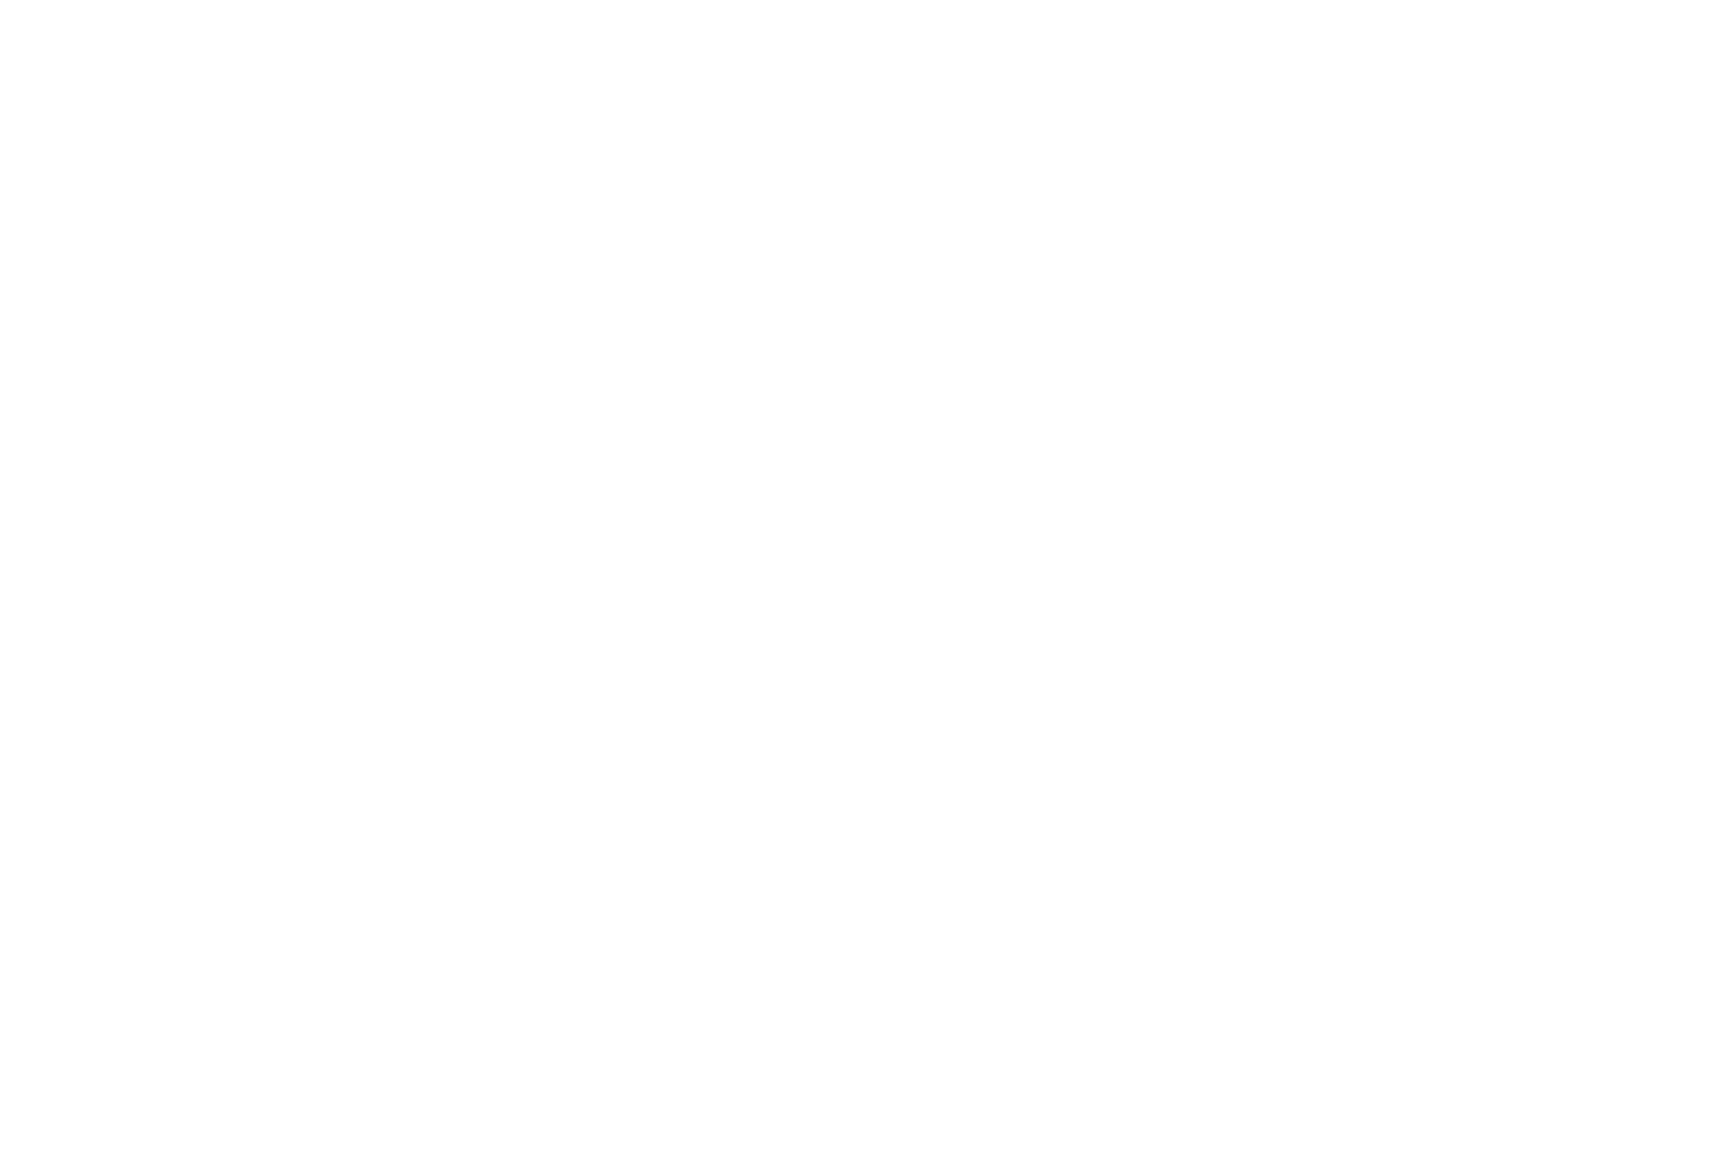

<IPython.core.display.Javascript object>


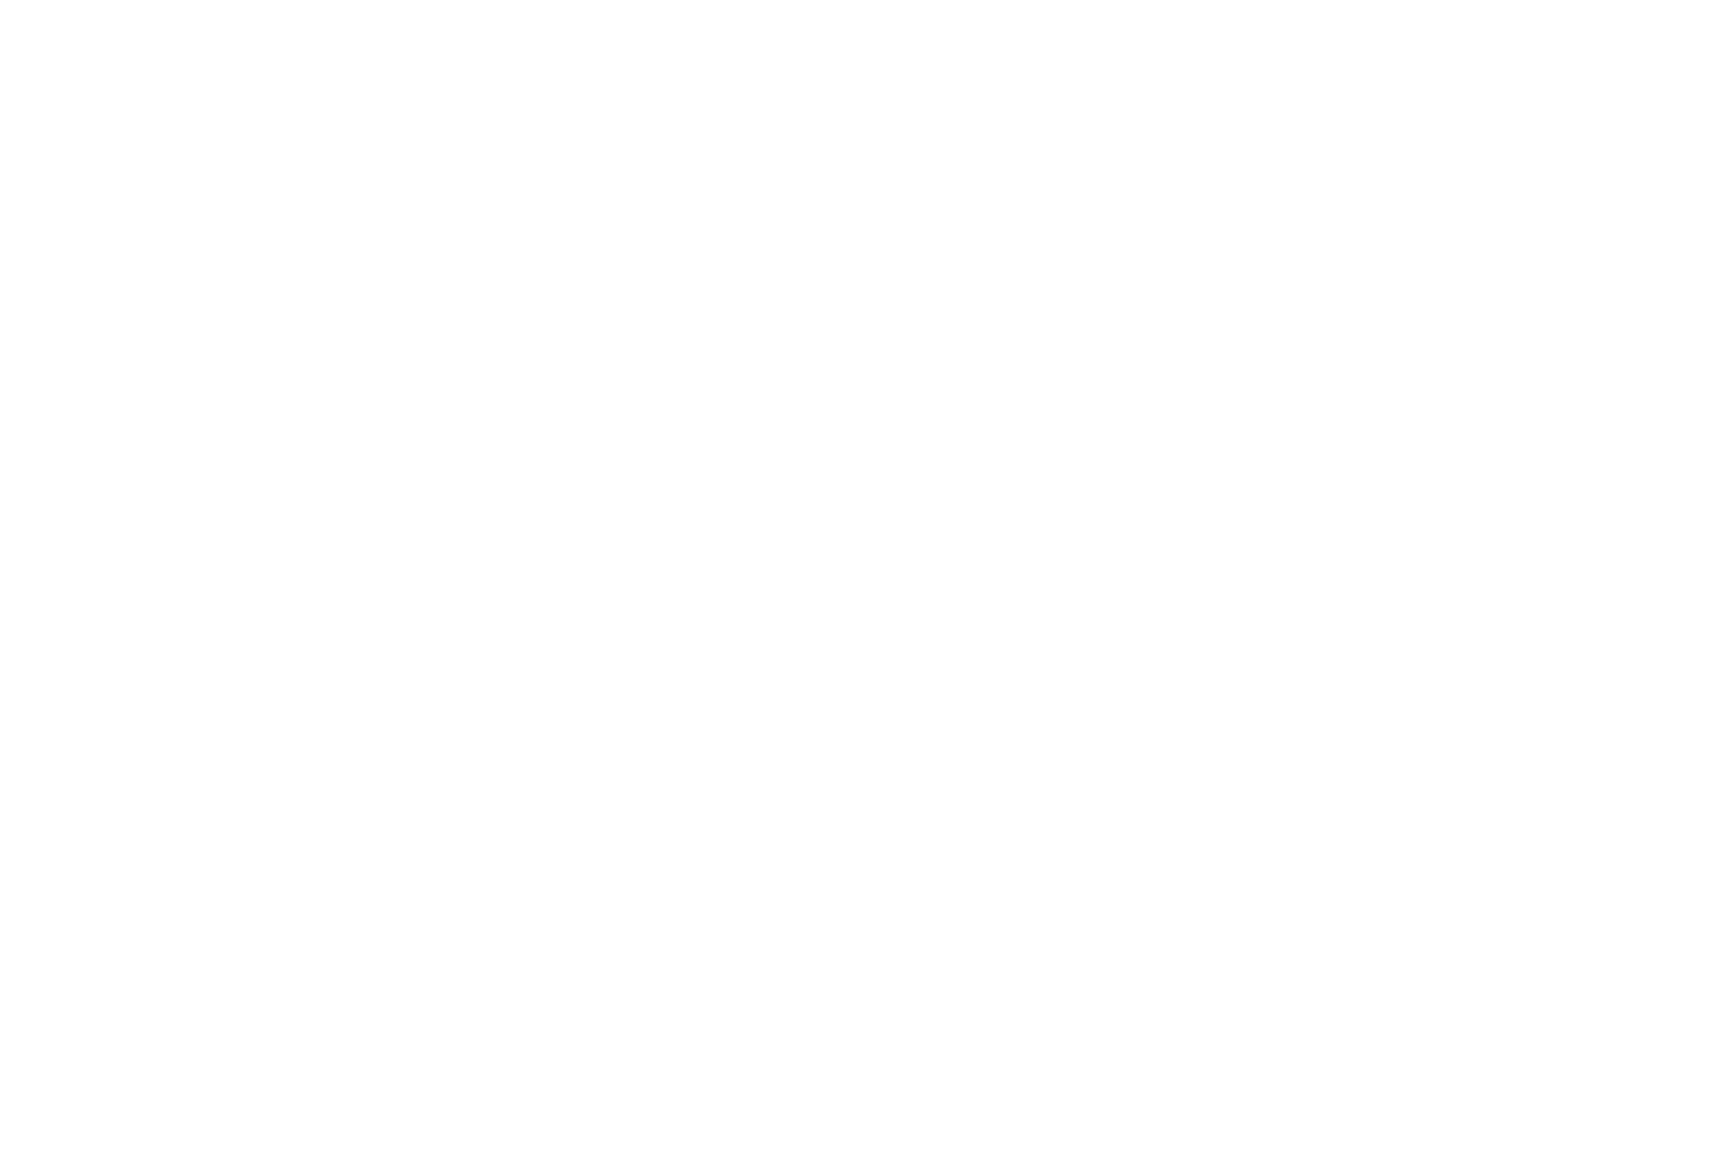

<IPython.core.display.Javascript object>


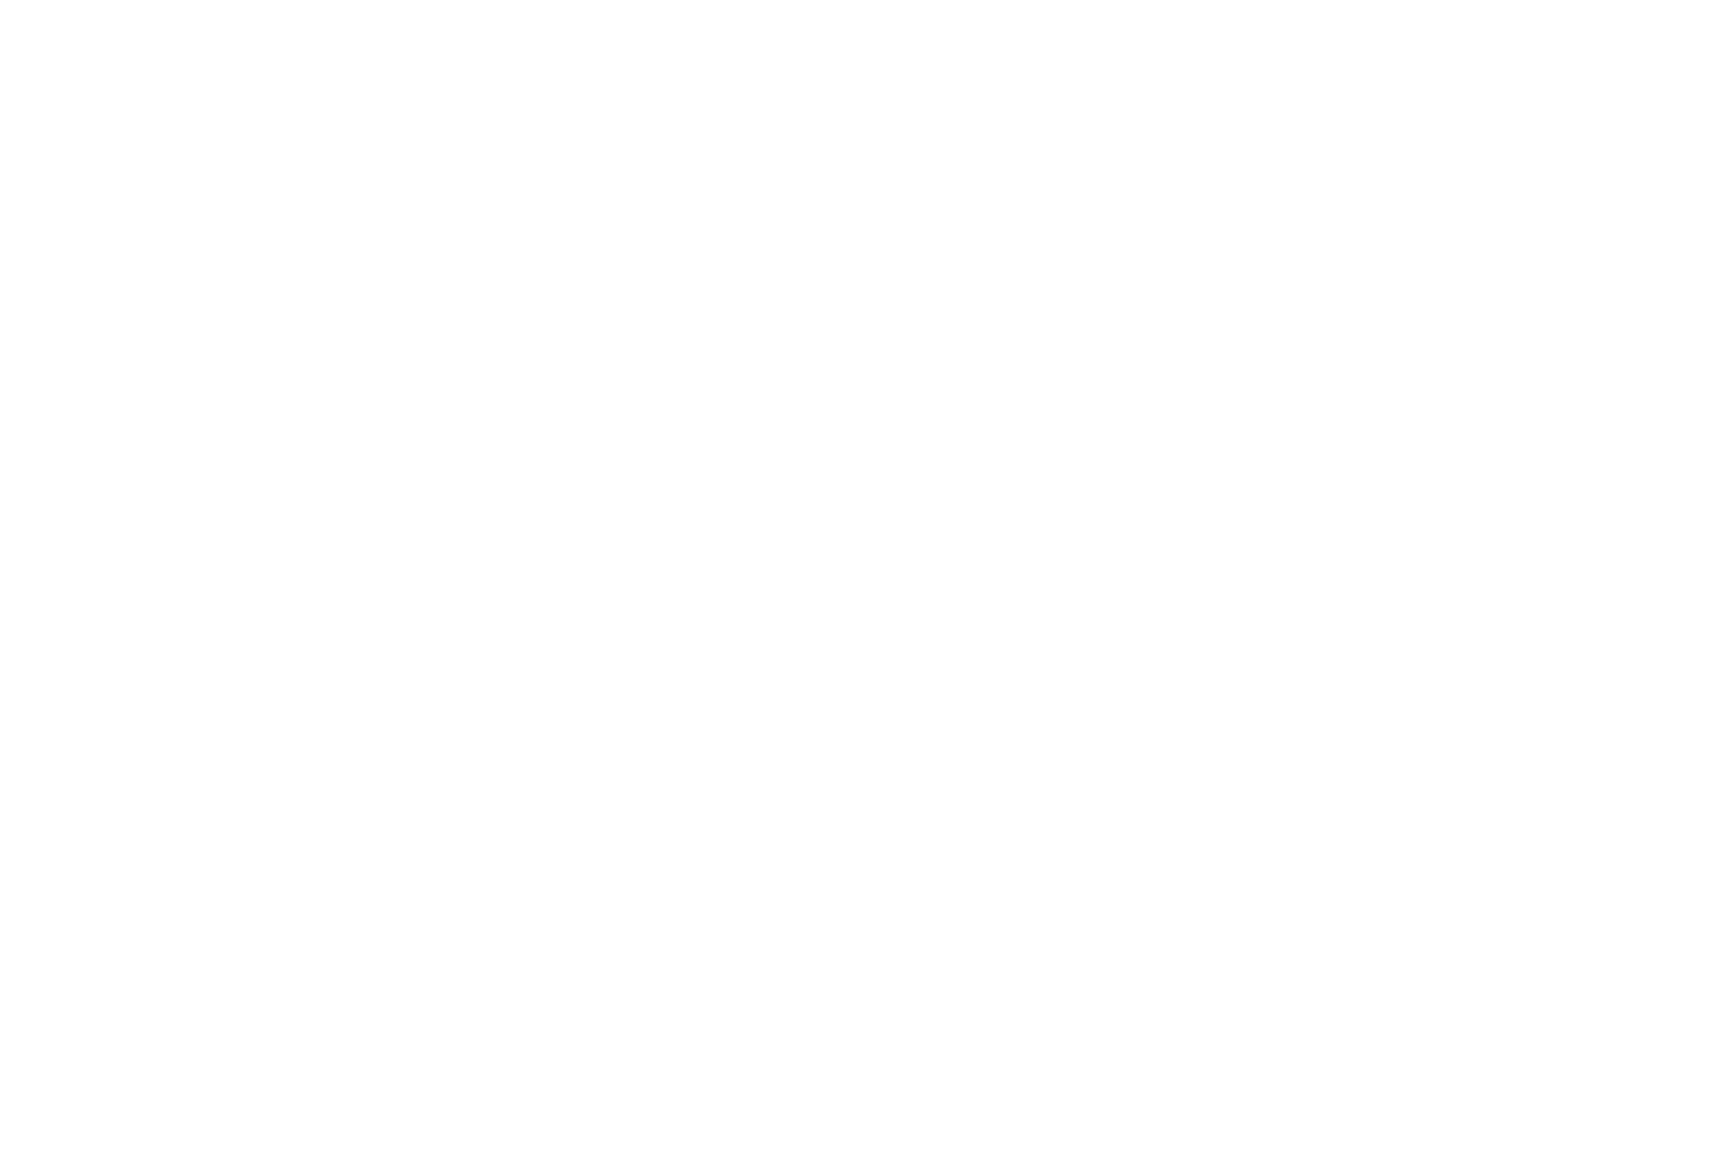

In [113]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.002, 0.004],
     'n_samples': [4700],
     'n_units': [16, 20, 24],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [100],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.004,
# 'n_samples': 44000 * 3,
# 'n_units': 20,
# 'batch_size': 500,
# 'epochs': 100,
# 'optimizer': keras.optimizers.Adam,
        
# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p)

globals().update(locals())

In [114]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


,round_epochs,loss,lr,batch_size,epochs,lr,n_samples,n_units,optimizer
7,100,0.064101,0.00256,100,100,0.004,4700,20,<class 'keras.optimizers.Adam'>
8,100,0.073632,0.00256,100,100,0.004,4700,24,<class 'keras.optimizers.Adam'>
6,100,0.085991,0.00256,100,100,0.004,4700,16,<class 'keras.optimizers.Adam'>
3,100,0.088374,0.00128,100,100,0.002,4700,16,<class 'keras.optimizers.Adam'>
5,100,0.096870,0.00128,100,100,0.002,4700,24,<class 'keras.optimizers.Adam'>
4,100,0.106031,0.00128,100,100,0.002,4700,20,<class 'keras.optimizers.Adam'>
0,100,0.117395,0.00064,100,100,0.001,4700,16,<class 'keras.optimizers.Adam'>
2,100,0.124886,0.00064,100,100,0.001,4700,24,<class 'keras.optimizers.Adam'>
1,100,0.126163,0.00064,100,100,0.001,4700,20,<class 'keras.optimizers.Adam'>


In [115]:
best_params = r.data.loc[7]
best_params

round_epochs                                100
loss                                  0.0641015
lr                                      0.00256
batch_size                                  100
epochs                                      100
lr                                        0.004
n_samples                                  4700
n_units                                      20
optimizer       <class 'keras.optimizers.Adam'>
Name: 7, dtype: object

In [116]:
type(best_params)

pandas.core.series.Series

{'lr': 0.003, 'n_samples': 105200, 'n_units': 20, 'batch_size': 400, 'epochs': 100, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


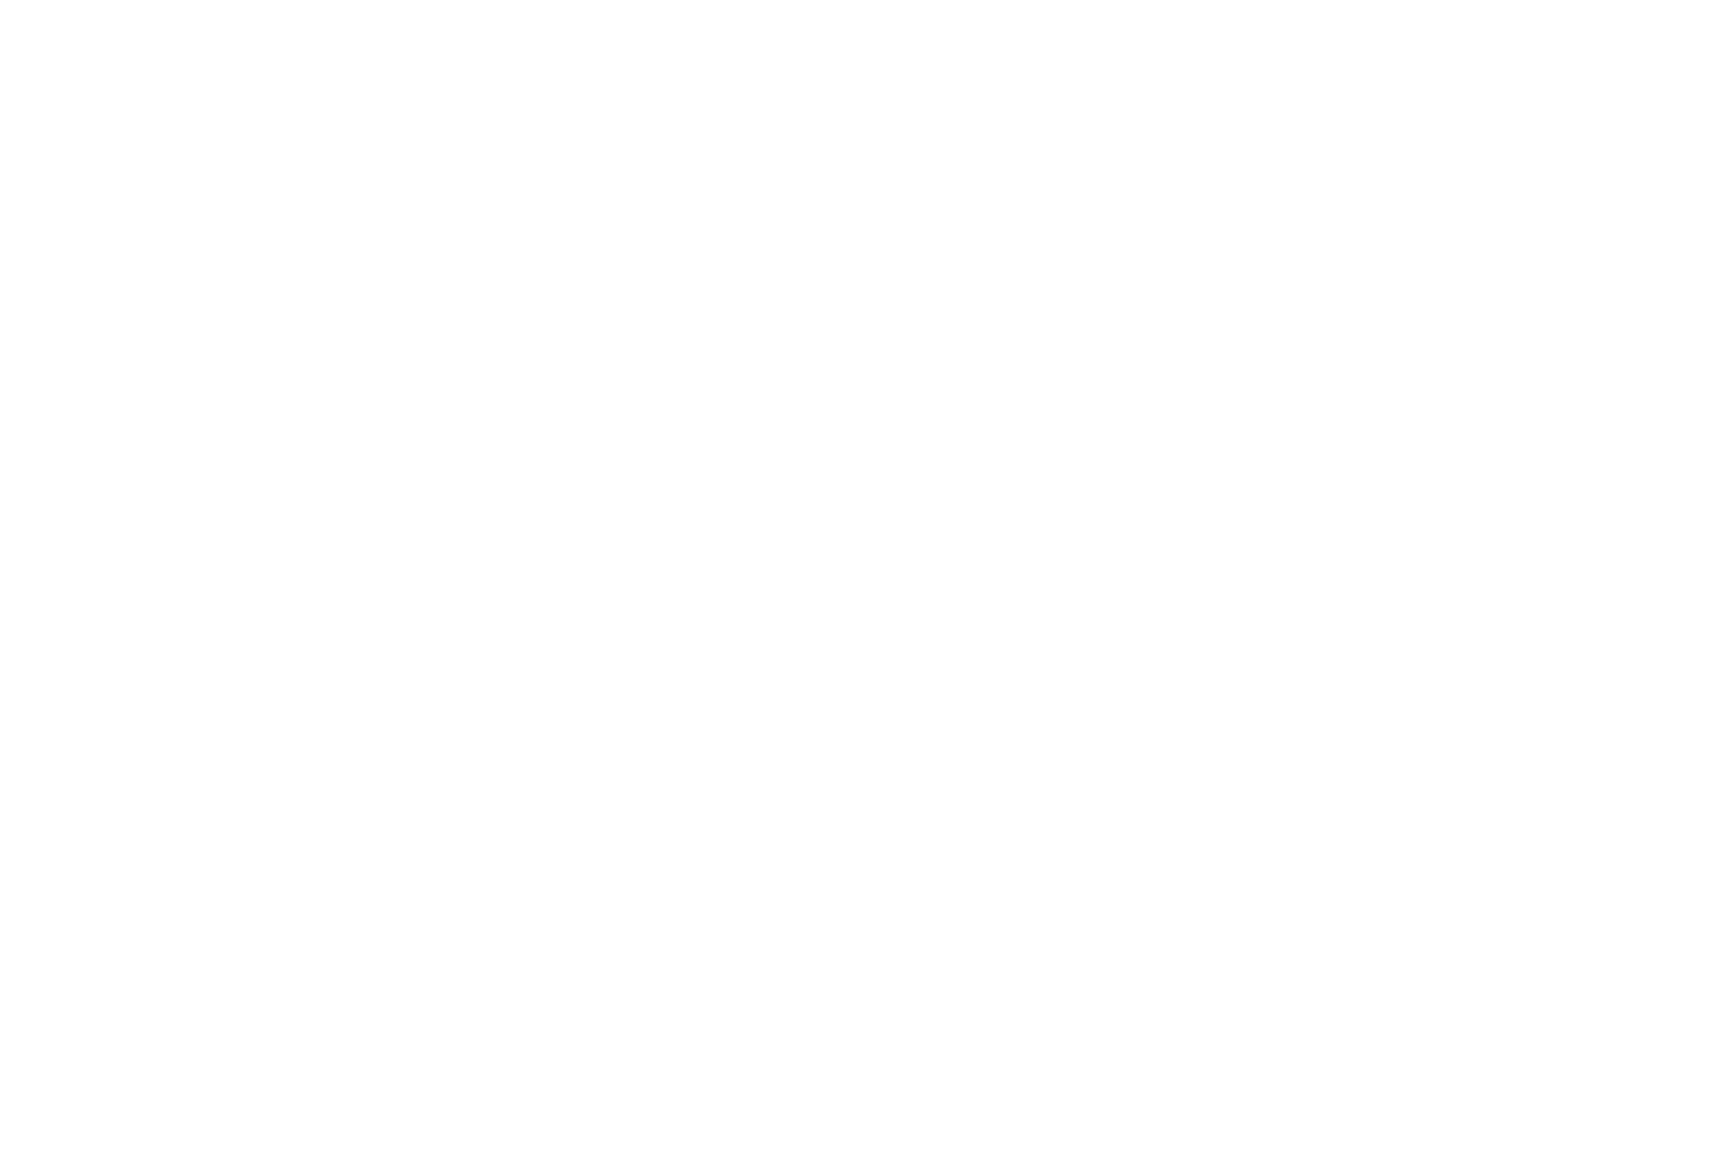

Epoch 1/100
105200/105200 [==============================] - 4s 37us/step - loss: 0.1834
Epoch 2/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.1592
Epoch 3/100
105200/105200 [==============================] - 3s 27us/step - loss: 0.1556
Epoch 4/100
105200/105200 [==============================] - 3s 28us/step - loss: 0.1526
Epoch 5/100
105200/105200 [==============================] - 3s 28us/step - loss: 0.1465
Epoch 6/100
105200/105200 [==============================] - 3s 28us/step - loss: 0.1416
Epoch 7/100
105200/105200 [==============================] - 3s 27us/step - loss: 0.1308
Epoch 8/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.1054
Epoch 9/100
105200/105200 [==============================] - 2s 23us/step - loss: 0.0877
Epoch 10/100
105200/105200 [==============================] - 2s 23us/step - loss: 0.0820
Epoch 11/100
105200/105200 [==============================] - 2s 23us/step - loss: 0.0774
Epoch 12/100
105200

105200/105200 [==============================] - 3s 26us/step - loss: 0.0374
Epoch 93/100
105200/105200 [==============================] - 3s 25us/step - loss: 0.0372
Epoch 94/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0366
Epoch 95/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0368
Epoch 96/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0372
Epoch 97/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0363
Epoch 98/100
105200/105200 [==============================] - 3s 25us/step - loss: 0.0367
Epoch 99/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0365
Epoch 100/100
105200/105200 [==============================] - 3s 26us/step - loss: 0.0364
CPU times: user 5min 13s, sys: 49.6 s, total: 6min 2s
Wall time: 4min 42s


<IPython.core.display.Javascript object>


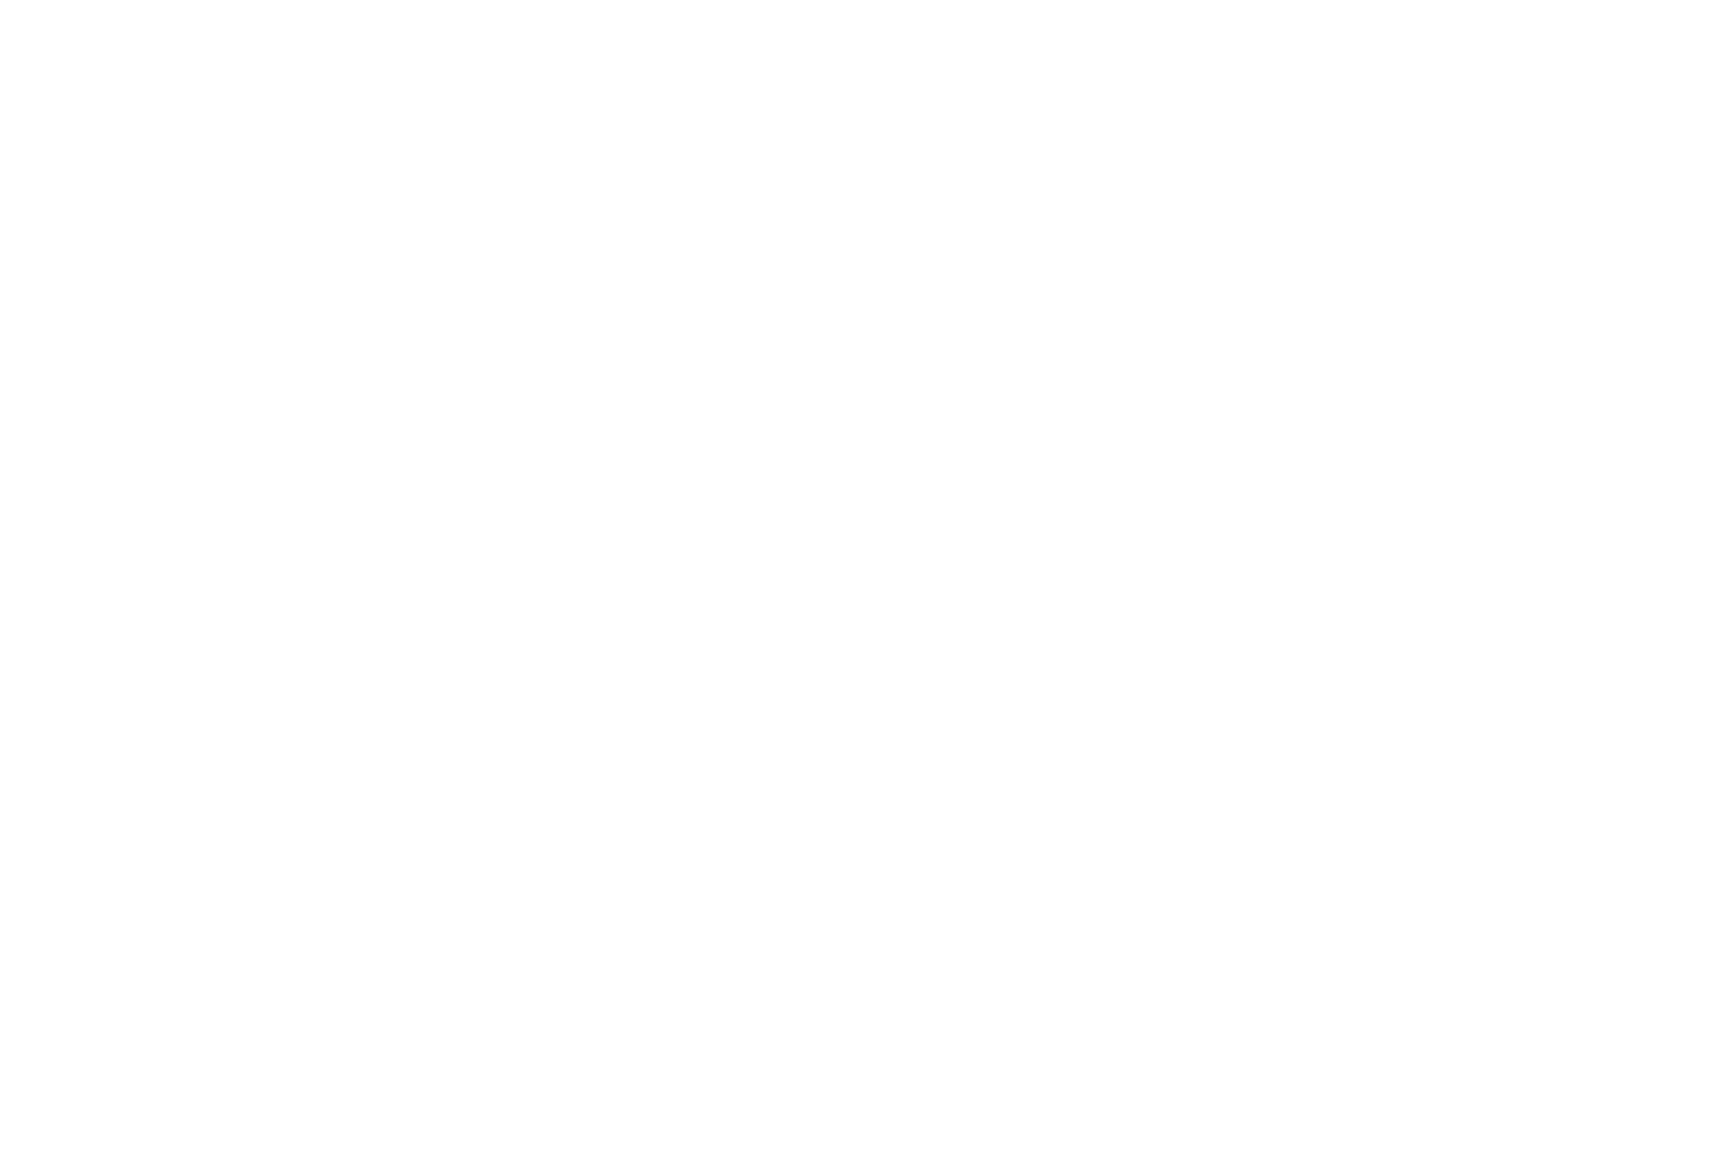

In [168]:
%%time
%matplotlib notebook

best_params = {
    'lr': 0.003,
    'n_samples': 105200,
    'n_units': 20,
    'batch_size': 400,
    'epochs': 100,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
)

globals().update(locals())

In [180]:
MAGIC_OFFSET = 300

In [119]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-5.3966969e-01, -1.1118026e+00, -6.5214407e-01,  9.0467781e-02,
        -7.2235221e-01,  4.8260581e-01, -6.0605955e-01, -1.3842185e-01,
        -2.6061434e-01,  8.8304833e-02,  1.1011589e-01,  2.7973908e-01,
         6.1423957e-01, -2.1717407e-01,  8.3118761e-01, -3.7578928e-01,
         6.8726093e-01, -6.4631248e-01,  1.5613700e+00,  5.1278162e-01,
        -4.3729395e-01, -3.6117285e-01,  6.4227974e-01,  4.5263919e-01,
         4.3617183e-01, -3.8658321e-02, -4.8670745e-01,  3.1484744e-01,
        -1.3100272e+00, -2.2906752e-01, -8.6041123e-01,  2.3242980e-01,
        -8.6732489e-01,  4.9291438e-01,  1.1274153e+00,  3.4383520e-01,
        -1.3006968e+00, -2.4181087e-01, -1.2096766e+00,  1.9387510e-01,
        -1.5844928e+00,  5.6355624e-03,  8.0028266e-01, -1.6290908e-01,
        -2.8568128e-01,  3.6738940e-02, -1.3105153e+00,  7.2539828e-05,
         4.2897728e-01,  7.4111395e-02,  1.2326586e+00,  7.1652941e-02,
         9.3506551e-01,  3.9850909e-02, -1.0747666e+00,  1.2

In [181]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (400, 64, 2)              0         
_________________________________________________________________
cu_dnngru_21 (CuDNNGRU)      (400, 64, 20)             1440      
_________________________________________________________________
cu_dnngru_22 (CuDNNGRU)      (400, 20)                 2520      
_________________________________________________________________
dense_11 (Dense)             (400, 1)                  21        
Total params: 3,981
Trainable params: 3,981
Non-trainable params: 0
_________________________________________________________________


In [121]:
# model.save('saved_models/02_peak_comp_60_samples_180_params.h5')

In [171]:
score = model.evaluate(X_te_s[:26000], y_te_s[:26000], verbose=0, batch_size=best_params['batch_size'])
score

0.040487171824161824

In [172]:
0.040487171824161824

0.040487171824161824

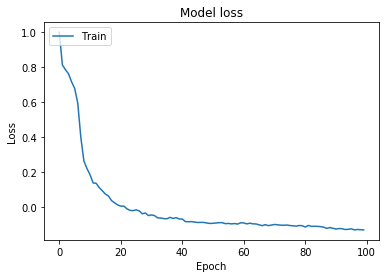

In [173]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [176]:
len(X_te_s)

26205

In [177]:
predict(model, X_te_s[:400], batch_size=best_params['batch_size'])

array([-2.39713699e-01, -2.58399040e-01, -2.70608962e-01, -2.78638035e-01,
       -2.85039753e-01, -2.90807784e-01, -2.97514170e-01, -3.05736572e-01,
       -3.17562759e-01, -3.31202030e-01, -3.41181874e-01, -3.40917468e-01,
       -3.24227810e-01, -2.86309659e-01, -2.27569282e-01, -1.59993783e-01,
       -6.14336319e-02,  1.78357437e-02,  6.93930238e-02,  1.01267233e-01,
        1.17106751e-01,  1.21997133e-01,  1.26037806e-01,  1.37259498e-01,
        1.49335101e-01,  1.60659507e-01,  1.73734158e-01,  1.86317205e-01,
        1.96991980e-01,  2.04095230e-01,  2.05399618e-01,  1.98686495e-01,
        1.83053404e-01,  1.59115583e-01,  1.26948476e-01,  8.91049057e-02,
        5.04704006e-02,  1.72133557e-02, -3.64798494e-03, -1.15401633e-02,
       -1.62716638e-02, -2.22799424e-02, -3.41845900e-02, -5.17455749e-02,
       -7.09625557e-02, -8.50886554e-02, -8.90829563e-02, -7.97654688e-02,
       -5.92301153e-02, -3.71720940e-02, -2.06123926e-02, -1.05988868e-02,
       -3.69270518e-03, -

In [178]:
print(X_tr_s[0][-1])

[-0.00759911  1.        ]


0   -0.052803
1   -0.067536
2   -0.084967
3   -0.102790
4   -0.118428
dtype: float32


Text(0,0.5,'value')

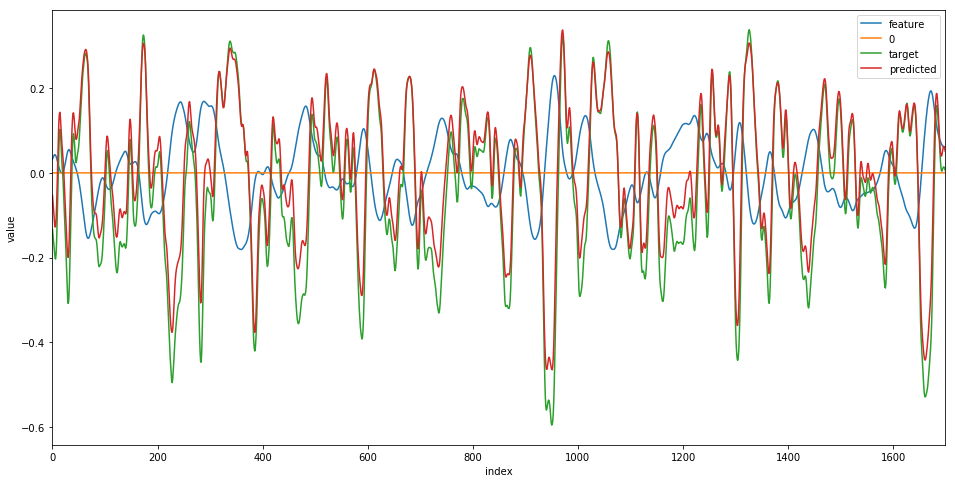

In [194]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 1700
OFFSET = int(MAGIC_OFFSET) + 1200

X_to_test = X_tr_s
y_to_test = y_tr_s

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_to_test[:(I + OFFSET)]))))[OFFSET:])

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[:(I + OFFSET)], batch_size=best_params['batch_size'])[OFFSET:])
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')


## Time to evaluate performance

In [276]:
X_to_repeat = X_tr_s[:int(44000 * 2.8)]
X_to_pred = np.concatenate([X_to_repeat, X_to_repeat, X_to_repeat])
len(X_to_pred) / 44000, X_to_pred[0][:4], X_to_pred[1][:4]

(8.399931818181818, array([[ 3.0518509e-05,  1.0000000e+00],
        [-1.5259255e-04,  1.0000000e+00],
        [-3.3570360e-04,  1.0000000e+00],
        [-5.4933317e-04,  1.0000000e+00]], dtype=float32), array([[-1.5259255e-04,  1.0000000e+00],
        [-3.3570360e-04,  1.0000000e+00],
        [-5.4933317e-04,  1.0000000e+00],
        [-7.3244423e-04,  1.0000000e+00]], dtype=float32))

In [277]:
def mapper(a):
    i = a[0]
    row = a[1]
    
    t = i / len(X_to_pred)
    gain = 1.0 * (1 - t) + 6.4 * t
    
    return np.array(list(map(lambda x: [x[0], gain], row)))

X_to_pred = np.array(list(map(mapper, enumerate(X_to_pred))))

X_to_pred[0][:5], X_to_pred[1][:5], X_to_pred[-2][:5], X_to_pred[-1][:5]

(array([[ 3.05185094e-05,  1.00000000e+00],
        [-1.52592547e-04,  1.00000000e+00],
        [-3.35703604e-04,  1.00000000e+00],
        [-5.49333170e-04,  1.00000000e+00],
        [-7.32444227e-04,  1.00000000e+00]]),
 array([[-1.52592547e-04,  1.00001461e+00],
        [-3.35703604e-04,  1.00001461e+00],
        [-5.49333170e-04,  1.00001461e+00],
        [-7.32444227e-04,  1.00001461e+00],
        [-9.15555283e-04,  1.00001461e+00]]),
 array([[-0.01727348,  6.39997078],
        [-0.01828059,  6.39997078],
        [-0.01968444,  6.39997078],
        [-0.02117985,  6.39997078],
        [-0.02221747,  6.39997078]]),
 array([[-0.01828059,  6.39998539],
        [-0.01968444,  6.39998539],
        [-0.02117985,  6.39998539],
        [-0.02221747,  6.39998539],
        [-0.02237007,  6.39998539]]))

In [278]:
predictions = predict(model, X_to_pred, batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

369200/369200 [==============================] - 3s 8us/step


(369200,
 array([-0.01366326, -0.0114784 , -0.00570081,  0.00043877,  0.00618004,
         0.00843205,  0.00941003,  0.01815676,  0.02887378,  0.03488084],
       dtype=float32),
 0.8575009,
 -0.87018764)

In [279]:
predictions_n = np.clip((predictions / 1.0) * 1.0, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(369200,
 array([-447.70404 , -376.1128  , -186.7985  ,   14.377125,  202.50151 ,
         276.29297 ,  308.33862 ,  594.9427  ,  946.10724 , 1142.9406  ],
       dtype=float32),
 28097.732,
 -28513.438)

In [280]:
wavfile.write('output/pred_out_gr_jump_head_gain_param_v2-slow-increase.wav', source_fs, predictions)

In [274]:
len(predictions) / 44000

9.0